## Métodos y funciones


In [1]:
!pip install validclust

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import datetime
import requests
import io

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import style
import seaborn as sns

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor

# Análisis Cluster
# ==============================================================================
from sklearn.cluster import KMeans # Algoritmo KMeans
from sklearn.metrics import silhouette_score # Método de validación silhouette
from sklearn.metrics import calinski_harabasz_score # Método de validación Calinski-Harabasz
from sklearn.metrics import davies_bouldin_score # Método de validación Davies Bouldin
from validclust.indices import dunn # Método de validación Dunn
from yellowbrick.cluster import KElbowVisualizer # Visualizador del diagrama del codo
from sklearn.metrics import pairwise_distances

# Modelado
# ==============================================================================
#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Creación de modelo
import statsmodels.api as sm
#from sklearn.linear_model import LinearRegression

#Factor de Inflación de la Varianza VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
# Función visualización de multiples gráficas
# ==============================================================================

def plot_multiples_graficas(df, cols, num_cols, num_rows, tipo, targetVar, figsize=(16,8)):

    plt.rcParams['figure.figsize'] = figsize


    fig, axs = plt.subplots(num_rows, num_cols)

    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols

        if num_rows == 1:
            if num_cols == 1:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs, dodge = False)
                    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs)
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs)
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[j])
        else:
            if num_cols == 1:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[i], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i])
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[i, j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i, j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i, j])

In [5]:
#Función para calcular VIF (Variance Inflation Factor):

#Se Utiliza VIF para solucionar la multicolinealidad. VIF indica el grado de indecencia de esa variable.
#Los valores de los umbrales típicos que se suelen utilizar son entre 5 y 10, siendo más exigentes los valores más bajos.

def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

In [6]:
# Función para contruir un modelo de regresión lineal por medio de statsmodels.api

def build_model(X,y):

    #A los datos de entrada 'X' se le adiciona una constante
    X = sm.add_constant(X)

    #Se crea y se entrena el modelo de regresion lineal q(statsmodels.api) con
    #los datos de entrada 'X' y los datos de salida 'y'
    lm = sm.OLS(y,X).fit()

    #imprime el resumen del modelo creado
    print(lm.summary()) # model summary

    return X

In [7]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

# Exploración de datos


## Dataset

Nuestro dataset contiene datos reales proporcionados por la organización Evertec Placetopay quien ofrece servicios de pagos, analítica y seguridad transaccional. Actualmente, la compañía no tiene una clasificación robusta de sus clientes, por ende, sus servicios y negociaciones no están discriminadas por el tipo de cliente. De esta manera, los datos contenidos en el dataset nos informan acerca del comportamiento de los clientes de la compañía un período de 2021 a 2023.

Nuestro objetivo es realizar un análisis clustering para segmentar los clientes con una predicción de etiquetado, y, posteriormente, pasar a una predicción de regresión para identificar cuánto transará un comercio con la compañía.

**En este paper, buscamos una aproximación inicial a los datos**.

In [8]:
# Leemos el archivo
comercios_df = pd.read_excel('/Comercios_Placetopay.xlsx')
pd.set_option('display.max_columns',None)
comercios_df.head(5)

,transaction_processing_period,merchant_address_country,merchant_address_city,merchant_id,Sitios activos,isic_section_name,isic_division_name,merchant_mcc,merchant_ciiu,merchant_classification,merchant_created,merchant_parent,merchant_size,merchant_is_iata_travelagency,merchant_enabled,transacciones mes,Monto mes USD,Pagadores mes,site_id,site_enabled,site_live,site_classification,avg ticket,last transaction date,approval rate,Disputes
0,202203.0,CO,Bogota,CO0000000017,1,ACTIVIDADES FINANCIERAS Y DE SEGUROS,"Seguros (incluso el reaseguro), seguros social...",6300,6511,A+,2003-06-27,CO0000000598,L,0,Activo,"42.067,00","$ 4.210.319,35",26110,CO0000002175,Activo,2014-08-29,Recaudo,"$ 154,30",2022-03-31,65.0,1042
1,202211.0,CO,Bogota,CO0000000233,1,ACTIVIDADES FINANCIERAS Y DE SEGUROS,"Seguros (incluso el reaseguro), seguros social...",6300,6511,A+,2008-06-25,CO0000000204,L,0,Activo,"1.628,00","$ 100.841,81",413,CO0000005714,Activo,2020-12-07,Recaudo,"$ 123,43",2022-11-30,5.0,801
2,202204.0,CO,Bogota,CO0000000017,1,ACTIVIDADES FINANCIERAS Y DE SEGUROS,"Seguros (incluso el reaseguro), seguros social...",6300,6511,A+,2003-06-27,CO0000000598,L,0,Activo,"28.929,00","$ 2.562.006,34",17170,CO0000002175,Activo,2014-08-29,Recaudo,"$ 156,12",2022-04-30,57.0,619
3,202212.0,CO,Bogota,CO0000000951,1,ACTIVIDADES FINANCIERAS Y DE SEGUROS,"Seguros (incluso el reaseguro), seguros social...",6300,6511,A+,2015-10-20,CO0000000951,L,0,Activo,"53.338,00","$ 5.287.959,05",24077,CO0000002945,Activo,2017-05-05,E-Commerce,"$ 128,90",2022-12-31,77.0,344
4,202201.0,CO,Bogota,CO0000000017,1,ACTIVIDADES FINANCIERAS Y DE SEGUROS,"Seguros (incluso el reaseguro), seguros social...",6300,6511,A+,2003-06-27,CO0000000598,L,0,Activo,"39.687,00","$ 4.149.853,66",25483,CO0000002175,Activo,2014-08-29,Recaudo,"$ 148,86",2022-01-31,7.0,309


In [9]:
# Miramos tamaño e información del dataset. Aparentemente no hay datos nulos.
comercios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108512 entries, 0 to 108511
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   transaction_processing_period  88556 non-null   float64       
 1   merchant_address_country       108512 non-null  object        
 2   merchant_address_city          108512 non-null  object        
 3   merchant_id                    108512 non-null  object        
 4   Sitios activos                 108512 non-null  int64         
 5   isic_section_name              108512 non-null  object        
 6   isic_division_name             108512 non-null  object        
 7   merchant_mcc                   108512 non-null  object        
 8   merchant_ciiu                  108086 non-null  object        
 9   merchant_classification        108512 non-null  object        
 10  merchant_created               108512 non-null  datetime64[ns]
 11  

In [10]:
# Corroboramos el contenido de cada variable
# Se identifica que en algunas variables como transaction_processing_period, isic_section_name, isic_division_name, etc., contienen el carácter "-".
# Confirmando con la compañía se asume el carácter "-" como datos nulos.

for category in comercios_df.columns:
  print(category)
  print('\n')
  display(comercios_df[category].astype('category'))
  print('\n')

transaction_processing_period




/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0         202203.0
1         202211.0
2         202204.0
3         202212.0
4         202201.0
            ...   
108507         NaN
108508         NaN
108509         NaN
108510         NaN
108511         NaN
Name: transaction_processing_period, Length: 108512, dtype: category
Categories (31, float64): [202012.0, 202101.0, 202102.0, 202103.0, ..., 202303.0, 202304.0, 202305.0,
                           202306.0]



merchant_address_country




0         CO
1         CO
2         CO
3         CO
4         CO
          ..
108507    UY
108508    UY
108509    UY
108510    UY
108511    UY
Name: merchant_address_country, Length: 108512, dtype: category
Categories (10, object): ['BZ', 'CL', 'CO', 'CR', ..., 'HN', 'PA', 'PR', 'UY']



merchant_address_city




0             Bogota
1             Bogota
2             Bogota
3             Bogota
4             Bogota
             ...    
108507    Montevideo
108508    Montevideo
108509    Montevideo
108510    Montevideo
108511    Montevideo
Name: merchant_address_city, Length: 108512, dtype: category
Categories (672, object): ['Acacias', 'Adjuntas', 'Aguachica', 'Aguada', ..., 'Ñiquen', 'Ñuble',
                           'Ñuñoa', 'Ñuñoa -Santiago']



merchant_id




0         CO0000000017
1         CO0000000233
2         CO0000000017
3         CO0000000951
4         CO0000000017
              ...     
108507    UY0000000023
108508    UY0000000027
108509    UY0000000026
108510    UY0000000030
108511    UY0000000028
Name: merchant_id, Length: 108512, dtype: category
Categories (17918, object): ['BZ0000000007', 'BZ0000000008', 'BZ0000000009', 'BZ0000000010', ...,
                             'UY0000000030', 'UY0000000031', 'UY0000000032', 'UY0000000033']



Sitios activos




0         1
1         1
2         1
3         1
4         1
         ..
108507    1
108508    1
108509    1
108510    1
108511    1
Name: Sitios activos, Length: 108512, dtype: category
Categories (2, int64): [0, 1]



isic_section_name




0         ACTIVIDADES FINANCIERAS Y DE SEGUROS
1         ACTIVIDADES FINANCIERAS Y DE SEGUROS
2         ACTIVIDADES FINANCIERAS Y DE SEGUROS
3         ACTIVIDADES FINANCIERAS Y DE SEGUROS
4         ACTIVIDADES FINANCIERAS Y DE SEGUROS
                          ...                 
108507                                       -
108508                                       -
108509                                       -
108510                                       -
108511                                       -
Name: isic_section_name, Length: 108512, dtype: category
Categories (21, object): ['-', 'ACTIVIDADES ARTÍSTICAS, DE ENTRETENIMIENTO Y ...,
                          'ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y ..., 'ACTIVIDADES DE ORGANIZACIONES Y ENTIDADES EXT..., ...,
                          'INFORMACIÓN Y COMUNICACIONES', 'OTRAS ACTIVIDADES DE SERVICIOS',
                          'SUMINISTRO DE ELECTRICIDAD, GAS, VAPOR Y AIRE..., 'TRANSPORTE Y ALMACENAMIENTO']



isic_division_name




0         Seguros (incluso el reaseguro), seguros social...
1         Seguros (incluso el reaseguro), seguros social...
2         Seguros (incluso el reaseguro), seguros social...
3         Seguros (incluso el reaseguro), seguros social...
4         Seguros (incluso el reaseguro), seguros social...
                                ...                        
108507                                                    -
108508                                                    -
108509                                                    -
108510                                                    -
108511                                                    -
Name: isic_division_name, Length: 108512, dtype: category
Categories (74, object): ['-', 'Actividades administrativas y de apoyo de ofi...,
                          'Actividades auxiliares de las actividades de ..., 'Actividades cinematográficas, de video y prod..., ...,
                          'Telecomunicaciones', 'Transporte acuátic



merchant_mcc




0         6300
1         6300
2         6300
3         6300
4         6300
          ... 
108507    5691
108508    5812
108509    5311
108510    8675
108511    5691
Name: merchant_mcc, Length: 108512, dtype: category
Categories (258, object): ['-', '1520', '1711', '1731', ..., '8931', '8999', '9311', '9399']



merchant_ciiu




0         6511
1         6511
2         6511
3         6511
4         6511
          ... 
108507       -
108508       -
108509       -
108510       -
108511       -
Name: merchant_ciiu, Length: 108512, dtype: category
Categories (355, object): ['-', '10', '1001', '1011', ..., '9602', '9603', '9609', '9999']



merchant_classification




0         A+
1         A+
2         A+
3         A+
4         A+
          ..
108507     N
108508     N
108509     N
108510     N
108511     N
Name: merchant_classification, Length: 108512, dtype: category
Categories (6, object): ['A', 'A+', 'B', 'B+', 'C', 'N']



merchant_created




0        2003-06-27
1        2008-06-25
2        2003-06-27
3        2015-10-20
4        2003-06-27
            ...    
108507   2023-05-11
108508   2023-05-19
108509   2023-05-16
108510   2023-05-26
108511   2023-05-24
Name: merchant_created, Length: 108512, dtype: category
Categories (2079, datetime64[ns]): [2002-07-05, 2002-07-24, 2003-05-09, 2003-05-14, ..., 2023-05-29,
                                    2023-05-30, 2023-05-31, 2023-06-01]



merchant_parent




0         CO0000000598
1         CO0000000204
2         CO0000000598
3         CO0000000951
4         CO0000000598
              ...     
108507    UY0000000023
108508    UY0000000027
108509    UY0000000026
108510    UY0000000030
108511    UY0000000028
Name: merchant_parent, Length: 108512, dtype: category
Categories (17756, object): ['BZ0000000007', 'BZ0000000008', 'BZ0000000009', 'BZ0000000010', ...,
                             'UY0000000030', 'UY0000000031', 'UY0000000032', 'UY0000000033']



merchant_size




0         L
1         L
2         L
3         L
4         L
         ..
108507    -
108508    -
108509    -
108510    -
108511    -
Name: merchant_size, Length: 108512, dtype: category
Categories (5, object): ['-', 'L', 'M', 'S', 'XS']



merchant_is_iata_travelagency




0         0
1         0
2         0
3         0
4         0
         ..
108507    0
108508    0
108509    0
108510    0
108511    0
Name: merchant_is_iata_travelagency, Length: 108512, dtype: category
Categories (2, int64): [0, 1]



merchant_enabled




0         Activo
1         Activo
2         Activo
3         Activo
4         Activo
           ...  
108507    Activo
108508    Activo
108509    Activo
108510    Activo
108511    Activo
Name: merchant_enabled, Length: 108512, dtype: category
Categories (2, object): ['Activo', 'Inactivo']



transacciones mes




0         42.067,00
1          1.628,00
2         28.929,00
3         53.338,00
4         39.687,00
            ...    
108507            0
108508            0
108509            0
108510            0
108511            0
Name: transacciones mes, Length: 108512, dtype: category
Categories (6234, object): ['0', '1', '1.000,00', '1.001,00', ..., '996', '997', '998', '999']



Monto mes USD




0         $ 4.210.319,35
1           $ 100.841,81
2         $ 2.562.006,34
3         $ 5.287.959,05
4         $ 4.149.853,66
               ...      
108507            $ 0,00
108508            $ 0,00
108509            $ 0,00
108510            $ 0,00
108511            $ 0,00
Name: Monto mes USD, Length: 108512, dtype: category
Categories (73985, object): ['$ 0,00', '$ 0,01', '$ 0,02', '$ 0,03', ..., '-$ 6,00', '-$ 7.412,12',
                             '-$ 7.600,00', '-$ 9.000,00']



Pagadores mes




0         26110
1           413
2         17170
3         24077
4         25483
          ...  
108507        0
108508        0
108509        0
108510        0
108511        0
Name: Pagadores mes, Length: 108512, dtype: category
Categories (4886, int64): [0, 1, 2, 3, ..., 192745, 192809, 197370, 198685]



site_id




0         CO0000002175
1         CO0000005714
2         CO0000002175
3         CO0000002945
4         CO0000002175
              ...     
108507    UY0000000026
108508    UY0000000031
108509    UY0000000030
108510    UY0000000034
108511    UY0000000032
Name: site_id, Length: 108512, dtype: category
Categories (29408, object): ['-', 'BZ0000000004', 'BZ0000000005', 'BZ0000000006', ...,
                             'UY0000000035', 'UY0000000036', 'UY0000000037', 'UY0000000038']



site_enabled




0         Activo
1         Activo
2         Activo
3         Activo
4         Activo
           ...  
108507    Activo
108508    Activo
108509    Activo
108510    Activo
108511    Activo
Name: site_enabled, Length: 108512, dtype: category
Categories (3, object): ['-', 'Activo', 'Inactivo']



site_live




0        2014-08-29
1        2020-12-07
2        2014-08-29
3        2017-05-05
4        2014-08-29
            ...    
108507   2023-05-17
108508   2023-05-19
108509   2023-05-17
108510   2023-05-29
108511   2023-05-25
Name: site_live, Length: 108512, dtype: category
Categories (2701, datetime64[ns]): [2002-07-17, 2002-07-18, 2002-07-24, 2002-08-06, ..., 2023-05-29,
                                    2023-05-30, 2023-05-31, 2023-06-01]



site_classification




0            Recaudo
1            Recaudo
2            Recaudo
3         E-Commerce
4            Recaudo
             ...    
108507       Recaudo
108508       Recaudo
108509       Recaudo
108510       Recaudo
108511       Recaudo
Name: site_classification, Length: 108512, dtype: category
Categories (3, object): ['-', 'E-Commerce', 'Recaudo']



avg ticket




0         $ 154,30
1         $ 123,43
2         $ 156,12
3         $ 128,90
4         $ 148,86
            ...   
108507           -
108508           -
108509           -
108510           -
108511           -
Name: avg ticket, Length: 108512, dtype: category
Categories (47088, object): ['$ 0,00', '$ 0,01', '$ 0,02', '$ 0,03', ..., '-$ 3,00', '-$ 3.706,06',
                             '-$ 415,82', '-$ 56,67']



last transaction date




0        2022-03-31
1        2022-11-30
2        2022-04-30
3        2022-12-31
4        2022-01-31
            ...    
108507          NaT
108508          NaT
108509          NaT
108510          NaT
108511          NaT
Name: last transaction date, Length: 108512, dtype: category
Categories (913, datetime64[ns]): [2020-12-01, 2020-12-02, 2020-12-03, 2020-12-04, ..., 2023-05-29,
                                   2023-05-30, 2023-05-31, 2023-06-01]



approval rate




/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0         65.0
1          5.0
2         57.0
3         77.0
4          7.0
          ... 
108507     NaN
108508     NaN
108509     NaN
108510     NaN
108511     NaN
Name: approval rate, Length: 108512, dtype: category
Categories (91, float64): [0.0, 1.0, 2.0, 3.0, ..., 96.0, 97.0, 98.0, 99.0]



Disputes




0         1042
1          801
2          619
3          344
4          309
          ... 
108507       0
108508       0
108509       0
108510       0
108511       0
Name: Disputes, Length: 108512, dtype: category
Categories (53, int64): [0, 1, 2, 3, ..., 344, 619, 801, 1042]

## Creación de variables


Antes de proceder con la limpieza y tratamiento de nuestros datos, decidimos agregar unas variables que consideramos aportan un entendimiento del comportamiento de los comercios para el negocio.



*   Se decide crear la columna **`'years_created'`** que especifique la cantidad de tiempo (en años) que lleva el comercio de ser creado.


*   Se crea variable **`"years_live"`** con la cantidad de tiempo (en años) desde los cuales el comercio creó el sitio

*   Se crea la variable **`"active status"`** en la que se especifica si el sitio se encuentra activo teniendo como criterio si ha transado alguna vez dentro del último año (1 para activos, 0 para inactivos).

*  Se decide crear la variable **`"agrupación mcc"`** para agrupar los valores de la variable 'merchant_mcc', y con esto disminuir la cantidad de categorías de dicha variable, de manera que cada grupo sea acorde a la actividad económica para cada comercio.






Para la creación de variables se deben reemplazar algunos valores ya identificados que son carácteres "-" y representan datos nulos

In [11]:
#Se reemplazan los valores "-" de la columna 'site_live' por un null para evitar errores
comercios_df['site_live'] = comercios_df['site_live'].replace('-', np.nan)

#Se reemplazan los valores "-" de la columna 'site_live' por un null para evitar errores
comercios_df['last transaction date'] = comercios_df['last transaction date'].replace('-', np.nan)
comercios_df = comercios_df.replace('-', np.nan)

#Se reemplazan los valores nulos de la columna 'merchant_mcc' con -1 para evitar errores en su posterior agrupamiento
comercios_df['merchant_mcc'] = comercios_df['merchant_mcc'].fillna(-1).astype(int)

Procedemos a crear las variables

In [12]:
#Creamos la variable 'years_created'
current_date = datetime.datetime.now().date()
comercios_df['merchant_created'] = pd.to_datetime(comercios_df['merchant_created']).dt.date
comercios_df['years_created'] = (current_date - comercios_df['merchant_created']).astype('timedelta64[Y]')

In [13]:
#Creamos la variable 'years_live'
comercios_df['site_live'] = pd.to_datetime(comercios_df['site_live']).dt.date
comercios_df['years_live'] = (current_date - comercios_df['site_live']).astype('timedelta64[Y]')

In [14]:
#Creamos la variable 'active status'
comercios_df['last transaction date'] = pd.to_datetime(comercios_df['last transaction date']).dt.date
comercios_df['active_status'] = (current_date - comercios_df['last transaction date']).dt.days <= 365
comercios_df['active_status'] = comercios_df['active_status'].astype(int)

In [15]:
#Creamos la variable 'agrupación'
rangos = [0, 1499, 2999, 3299, 3499, 3999, 4799, 4999, 5599, 5699, 7299, 7999, 8999, 9999]  # Definir los límites de los rangos
etiquetas = ['Agricultura','Servicios contractuales','Aerolíneas', 'Alquiler de vehículos',\
             'Alojamiento', 'Transporte', 'Servicios de utilidad', 'Minoristas',\
             'Textil', 'Miscelaneas', 'Negocios', 'Servicios profesionales y membresías',\
             'Gubernamentales']  # Definir los nombres de los grupos
comercios_df['merchant_mcc'] = comercios_df['merchant_mcc'].astype(int)
comercios_df['agrupación_mcc'] = pd.cut(comercios_df['merchant_mcc'], bins=rangos, labels=etiquetas, right=False)


*  Debido a que la columna `"merchant_mcc"` tiene muchas entradas sin valores, procedemos a utilizar la información encontrada en la columna `"isic_section_name"`correspondiente a dichas entradas con el fin de complementar los datos agrupados en la columna anteriormente creada **`"agrupación_mcc"`.**



In [16]:
condicion = comercios_df['merchant_mcc'] == -1

mapping = {
    'ACTIVIDADES FINANCIERAS Y DE SEGUROS': 'Miscelaneas',
    'ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE APOYO': 'Negocios',
    'INDUSTRIAS MANUFACTURERAS': 'Miscelaneas',
    'INFORMACIÓN Y COMUNICACIONES': 'Servicios de utilidad',
    'COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS': 'Minoristas',
    'ACTIVIDADES ARTÍSTICAS, DE ENTRETENIMIENTO Y RECREACIÓN': 'Negocios',
    'TRANSPORTE Y ALMACENAMIENTO': 'Transporte',
    'ADMINISTRACIÓN PÚBLICA Y DEFENSA; PLANES DE SEGURIDAD SOCIAL DE AFILIACIÓN OBLIGATORIA': 'Negocios',
    'ACTIVIDADES INMOBILIARIAS': 'Miscelaneas',
    'ALOJAMIENTO Y SERVICIOS DE COMIDA': 'Miscelaneas',
    'OTRAS ACTIVIDADES DE SERVICIOS': 'Miscelaneas',
    'EDUCACIÓN': 'Servicios profesionales y membresías',
    'ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y DE ASISTENCIA SOCIAL': 'Servicios profesionales y membresías',
    'ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNICAS': 'Servicios profesionales y membresías',
    'SUMINISTRO DE ELECTRICIDAD, GAS, VAPOR Y AIRE ACONDICIONADO': 'Servicios de utilidad',
    'AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y PESCA': 'Agricultura',
    'DISTRIBUCIÓN DE AGUA; EVACUACIÓN Y TRATAMIENTO DE AGUAS RESIDUALES, GESTIÓN DE DESECHOS Y ACTIVIDADES DE SANEAMIENTO AMBIENTAL': 'Servicios de utilidad',
    'CONSTRUCCIÓN': 'Minoristas',
    'ACTIVIDADES DE ORGANIZACIONES Y ENTIDADES EXTRATERRITORIALES': 'Servicios profesionales y membresías',
    'EXPLOTACIÓN DE MINAS Y CANTERAS': 'Agricultura'
}

comercios_df.loc[condicion, 'agrupación_mcc'] = comercios_df.loc[condicion, 'isic_section_name'].map(mapping)


*   Las variables **`"Monto mes USD"`** y **`"avg ticket"`** aparecen actualmente cómo tipo object por lo cual se procede a eliminar caracteres especiales ($) y a establecer su tipo como float.

*   De igual forma, se convierte la variable **`"transacciones mes"`**
 a tipo como float.


In [17]:
#Se elimina caracteres especiales las columnas "Monto mes USD", "avg ticket" y "transacciones mes"
comercios_df['Monto mes USD'] = comercios_df['Monto mes USD']\
.str.replace('$', '').str.replace('.', '').str.replace(',', '.').str.replace('-', '')
comercios_df['avg ticket'] = comercios_df['avg ticket']\
.str.replace('$', '').str.replace('.', '').str.replace(',', '.').str.replace('-', '')
comercios_df['transacciones mes'] = comercios_df['transacciones mes']\
.str.replace('.', '').str.replace(',', '.').str.replace('-', '')

<ipython-input-17-e5cc7fc73721>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('$', '').str.replace('.', '').str.replace(',', '.').str.replace('-', '')
<ipython-input-17-e5cc7fc73721>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('$', '').str.replace('.', '').str.replace(',', '.').str.replace('-', '')
<ipython-input-17-e5cc7fc73721>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('.', '').str.replace(',', '.').str.replace('-', '')


In [18]:
#Convertimos los valores a tipo numérico
comercios_df['Monto mes USD'] = pd.to_numeric(comercios_df['Monto mes USD'])
comercios_df['avg ticket'] = pd.to_numeric(comercios_df['avg ticket'])
comercios_df['transacciones mes'] = pd.to_numeric(comercios_df['transacciones mes'])

Observamos que ahora nuestro dataframe tiene las columnas que adicionamos


In [19]:
comercios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108512 entries, 0 to 108511
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   transaction_processing_period  88556 non-null   float64 
 1   merchant_address_country       108512 non-null  object  
 2   merchant_address_city          108512 non-null  object  
 3   merchant_id                    108512 non-null  object  
 4   Sitios activos                 108512 non-null  int64   
 5   isic_section_name              40695 non-null   object  
 6   isic_division_name             40695 non-null   object  
 7   merchant_mcc                   108512 non-null  int64   
 8   merchant_ciiu                  40772 non-null   object  
 9   merchant_classification        108512 non-null  object  
 10  merchant_created               108512 non-null  object  
 11  merchant_parent                108512 non-null  object  
 12  merchant_size   

## Limpieza de datos


**Se eliminan algunas columnas del dataframe.** Dicha decisión se justifica tras una conversación con el ingeniero de datos de la empresa.

*   La columna `"site_enabled"` proporciona la misma información que la columna `"Sitios activos"`. Por ende, se considera dejar la segunda ya que los datos se encuentran binarizados.

*   La columna `"merchant_address_city"` ya está contenida en la columna `"merchant_address_country"`

*   La columna `"merchant_ciiu"` solo aplica para comercios de Colombia, debido a que corresponde a una clasifiación de comercios de la DIAN. Mientras que, la columna `"merchant_mcc"` corresponde a una clasificación internacional.

*   Las columnas `"isic_section_name"` y `"isic_division_name"` dependen de la columna `"merchant_ciiu"` por lo que se incurre en la misma condición. Adicional, la variable `"isic_section_name"` está contenida en la nueva varibale `agrupación_mcc`


*   La variable `"merchant_classification"` es una clasificación actual que implementa la empresa. Se usará como variable ya que es un indicardor del volumen transaccional para cada comercio. Por otro lado la variable `"merchant_size"` parece ser tener correlación con la caracteriztica antes mencionada y por su gran cantidad de datos nulos, se decide eliminarla.

*   La información de las columnas `"merchant_mcc"`, `"merchant_created"`, `"merchant_parent"`, `"merchant_id"`,`"site_id'"`, `"site_live"` y `"last transaction date"` ya están contenidad en las variables creadas anteriormente o contienen información redundante.








In [20]:
comercios_df.drop(['site_enabled','merchant_address_city','merchant_ciiu','isic_section_name','isic_division_name','merchant_id','merchant_size','merchant_mcc','merchant_created','merchant_parent','site_id','site_live','last transaction date'],axis=1,inplace=True)
comercios_df.head()

,transaction_processing_period,merchant_address_country,Sitios activos,merchant_classification,merchant_is_iata_travelagency,merchant_enabled,transacciones mes,Monto mes USD,Pagadores mes,site_classification,avg ticket,approval rate,Disputes,years_created,years_live,active_status,agrupación_mcc
0,202203.0,CO,1,A+,0,Activo,42067.0,4210319.35,26110,Recaudo,154.30,65.0,1042,19.0,8.0,0,Miscelaneas
1,202211.0,CO,1,A+,0,Activo,1628.0,100841.81,413,Recaudo,123.43,5.0,801,14.0,2.0,1,Miscelaneas
2,202204.0,CO,1,A+,0,Activo,28929.0,2562006.34,17170,Recaudo,156.12,57.0,619,19.0,8.0,0,Miscelaneas
3,202212.0,CO,1,A+,0,Activo,53338.0,5287959.05,24077,E-Commerce,128.90,77.0,344,7.0,6.0,1,Miscelaneas
4,202201.0,CO,1,A+,0,Activo,39687.0,4149853.66,25483,Recaudo,148.86,7.0,309,19.0,8.0,0,Miscelaneas


### Dataframe númerico

Dividimos nuestro dataset para realizar un tratamiento de datos adecuado

In [21]:
# Dataset númerico
columns_num=['transaction_processing_period','transacciones mes','Monto mes USD','Pagadores mes','avg ticket','approval rate','Disputes','years_created','years_live']
comercios_num=comercios_df[columns_num]
display(comercios_num)


,transaction_processing_period,transacciones mes,Monto mes USD,Pagadores mes,avg ticket,approval rate,Disputes,years_created,years_live
0,202203.0,42067.0,4210319.35,26110,154.30,65.0,1042,19.0,8.0
1,202211.0,1628.0,100841.81,413,123.43,5.0,801,14.0,2.0
2,202204.0,28929.0,2562006.34,17170,156.12,57.0,619,19.0,8.0
3,202212.0,53338.0,5287959.05,24077,128.90,77.0,344,7.0,6.0
4,202201.0,39687.0,4149853.66,25483,148.86,7.0,309,19.0,8.0
...,...,...,...,...,...,...,...,...,...
108507,NaN,0.0,0.00,0,NaN,NaN,0,0.0,0.0
108508,NaN,0.0,0.00,0,NaN,NaN,0,0.0,0.0
108509,NaN,0.0,0.00,0,NaN,NaN,0,0.0,0.0
108510,NaN,0.0,0.00,0,NaN,NaN,0,0.0,0.0


In [22]:
#Verificamos que no hayan carácteres especiales
for category in comercios_num.columns:
  print(category)
  print('\n')
  display(comercios_num[category].astype('category'))
  print('\n')
  print(comercios_num[category].unique())
  print('\n')

transaction_processing_period




/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0         202203.0
1         202211.0
2         202204.0
3         202212.0
4         202201.0
            ...   
108507         NaN
108508         NaN
108509         NaN
108510         NaN
108511         NaN
Name: transaction_processing_period, Length: 108512, dtype: category
Categories (31, float64): [202012.0, 202101.0, 202102.0, 202103.0, ..., 202303.0, 202304.0, 202305.0,
                           202306.0]



[202203. 202211. 202204. 202212. 202201. 202207. 202205. 202208. 202206.
 202210. 202111. 202109. 202209. 202302. 202301. 202104. 202102. 202101.
 202103. 202012. 202105. 202107. 202108. 202110. 202106. 202202. 202112.
 202304. 202305. 202303. 202306.     nan]


transacciones mes




/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0         42067.0
1          1628.0
2         28929.0
3         53338.0
4         39687.0
           ...   
108507        0.0
108508        0.0
108509        0.0
108510        0.0
108511        0.0
Name: transacciones mes, Length: 108512, dtype: category
Categories (6234, float64): [0.0, 1.0, 2.0, 3.0, ..., 279132.0, 341043.0, 361600.0, 366932.0]



[42067.  1628. 28929. ...  1115.   986.     0.]


Monto mes USD




/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0         4210319.35
1          100841.81
2         2562006.34
3         5287959.05
4         4149853.66
             ...    
108507          0.00
108508          0.00
108509          0.00
108510          0.00
108511          0.00
Name: Monto mes USD, Length: 108512, dtype: category
Categories (73969, float64): [0.00, 0.01, 0.02, 0.03, ..., 59082178.79, 61376950.49, 61798412.96,
                              65468530.14]



[4.21031935e+06 1.00841810e+05 2.56200634e+06 ... 6.41180000e+02
 4.25700000e+01 6.42400000e+01]


Pagadores mes




0         26110
1           413
2         17170
3         24077
4         25483
          ...  
108507        0
108508        0
108509        0
108510        0
108511        0
Name: Pagadores mes, Length: 108512, dtype: category
Categories (4886, int64): [0, 1, 2, 3, ..., 192745, 192809, 197370, 198685]



[26110   413 17170 ...  2751  2647  1014]


avg ticket




/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0         154.30
1         123.43
2         156.12
3         128.90
4         148.86
           ...  
108507       NaN
108508       NaN
108509       NaN
108510       NaN
108511       NaN
Name: avg ticket, Length: 108512, dtype: category
Categories (47067, float64): [0.00, 0.01, 0.02, 0.03, ..., 1011430.05, 1028416.02, 1147575.59,
                              1222163.01]



[154.3  123.43 156.12 ... 830.96 536.21 641.18]


approval rate




/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0         65.0
1          5.0
2         57.0
3         77.0
4          7.0
          ... 
108507     NaN
108508     NaN
108509     NaN
108510     NaN
108511     NaN
Name: approval rate, Length: 108512, dtype: category
Categories (91, float64): [0.0, 1.0, 2.0, 3.0, ..., 96.0, 97.0, 98.0, 99.0]



[65.  5. 57. 77.  7.  4. 59. 37. 78. 54. 68. 49. 71. 39. 79. 72. 69. 75.
 64. 58. 52.  0. 82. 47. 45. 76. 38. 46. 48. 81. 67. 73.  8. 83. 84. 87.
 63. 21. 85. 86.  2. 61. 74. 22.  3. 91. 44. 66. 55. 29. 27. 89. 62. 43.
 88.  6. 11. 32. 56. 51. 23. 24.  9. 97. 15. 41. 95. 94. 42. 53. 92. 96.
 26. 93. 17.  1. 12. 35. 28. 36. 31. 25. 19. 14. 34. 13. 33. 98. 18. 16.
 99. nan]


Disputes




0         1042
1          801
2          619
3          344
4          309
          ... 
108507       0
108508       0
108509       0
108510       0
108511       0
Name: Disputes, Length: 108512, dtype: category
Categories (53, int64): [0, 1, 2, 3, ..., 344, 619, 801, 1042]



[1042  801  619  344  309  258  230  190  181  172  104   96   92   88
   70   65   62   56   53   49   44   43   42   41   39   36   32   30
   26   25   24   23   22   21   18   17   16   15   14   13   12   11
   10    9    8    7    6    5    4    3    2    1    0]


years_created




/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0         19.0
1         14.0
2         19.0
3          7.0
4         19.0
          ... 
108507     0.0
108508     0.0
108509     0.0
108510     0.0
108511     0.0
Name: years_created, Length: 108512, dtype: category
Categories (21, float64): [0.0, 1.0, 2.0, 3.0, ..., 17.0, 18.0, 19.0, 20.0]



[19. 14.  7.  6.  4. 11.  1. 18. 12.  3. 15.  2.  5.  8.  9. 13. 10. 17.
 16.  0. 20.]


years_live




/usr/local/lib/python3.10/dist-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0         8.0
1         2.0
2         8.0
3         6.0
4         8.0
         ... 
108507    0.0
108508    0.0
108509    0.0
108510    0.0
108511    0.0
Name: years_live, Length: 108512, dtype: category
Categories (21, float64): [0.0, 1.0, 2.0, 3.0, ..., 17.0, 18.0, 19.0, 20.0]



[ 8.  2.  6.  3.  5. 10.  0.  7. 12.  4. 15. 11.  1. 14.  9. 13. 18. 16.
 19. nan 17. 20.]




In [23]:
#Observamos el tamaño y datos nulos de nuestro dataframe númerico
comercios_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108512 entries, 0 to 108511
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   transaction_processing_period  88556 non-null   float64
 1   transacciones mes              108512 non-null  float64
 2   Monto mes USD                  108512 non-null  float64
 3   Pagadores mes                  108512 non-null  int64  
 4   avg ticket                     85329 non-null   float64
 5   approval rate                  88556 non-null   float64
 6   Disputes                       108512 non-null  int64  
 7   years_created                  108512 non-null  float64
 8   years_live                     91143 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 7.5 MB


In [24]:
#Identificamos el porcentaje de datos nulos por columna en el DataFrame númerico
for columna in comercios_num.columns:
  porcentaje=100*comercios_num[columna].isna().sum()/len(comercios_num[columna])
  print(f'El porcentaje de datos faltantes en la columna {columna} es de {round(porcentaje,2)}%')

El porcentaje de datos faltantes en la columna transaction_processing_period es de 18.39%
El porcentaje de datos faltantes en la columna transacciones mes es de 0.0%
El porcentaje de datos faltantes en la columna Monto mes USD es de 0.0%
El porcentaje de datos faltantes en la columna Pagadores mes es de 0.0%
El porcentaje de datos faltantes en la columna avg ticket es de 21.36%
El porcentaje de datos faltantes en la columna approval rate es de 18.39%
El porcentaje de datos faltantes en la columna Disputes es de 0.0%
El porcentaje de datos faltantes en la columna years_created es de 0.0%
El porcentaje de datos faltantes en la columna years_live es de 16.01%


**Imputación datos númericos**

Luego de la limpieza y la identificación de datos nulos, observamos que la cantidad de datos faltantes no supera el 20% en la mayoría de las columnas, por ende, decidimos proceder con la imputación de datos.

In [25]:
#Imputación variable KNN utilizando por parámetro la distancia euclidiana
com_num_imp = KNNImputer(missing_values = np.nan, n_neighbors = 5, weights= "distance")
com_num_imp.fit(comercios_num)
com_num_imp = com_num_imp.transform(comercios_num)

In [26]:
categorias_num = comercios_num.columns
com_num_imp = pd.DataFrame(com_num_imp, columns = categorias_num)

In [27]:
# Cambiamos el tipo de dato de transaction_processing_period
com_num_imp['transaction_processing_period'] = com_num_imp['transaction_processing_period'].astype(int)

In [28]:
com_num_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108512 entries, 0 to 108511
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   transaction_processing_period  108512 non-null  int64  
 1   transacciones mes              108512 non-null  float64
 2   Monto mes USD                  108512 non-null  float64
 3   Pagadores mes                  108512 non-null  float64
 4   avg ticket                     108512 non-null  float64
 5   approval rate                  108512 non-null  float64
 6   Disputes                       108512 non-null  float64
 7   years_created                  108512 non-null  float64
 8   years_live                     108512 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 7.5 MB


In [29]:
com_num_imp.describe()

,transaction_processing_period,transacciones mes,Monto mes USD,Pagadores mes,avg ticket,approval rate,Disputes,years_created,years_live
count,108512.000000,108512.000000,1.085120e+05,108512.000000,1.085120e+05,108512.000000,108512.000000,108512.000000,108512.000000
mean,202203.053718,920.285121,1.148076e+05,510.352394,9.388332e+02,36.133002,0.060583,3.985264,2.663238
std,77.296544,7372.643142,1.171218e+06,4450.842437,1.492952e+04,37.062917,4.931787,4.514962,3.040676
min,202012.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,202111.000000,1.000000,2.000000e+00,1.000000,1.140000e+00,1.000000,0.000000,1.000000,0.800000
50%,202207.000000,10.000000,1.155720e+03,5.000000,7.424500e+01,9.000000,0.000000,3.000000,2.000000
75%,202285.000000,79.000000,1.185620e+04,37.000000,3.475825e+02,75.000000,0.000000,4.000000,3.000000
max,202306.000000,366932.000000,6.546853e+07,198685.000000,1.222163e+06,99.000000,1042.000000,20.000000,20.000000


**Escalamiento datos númericos**

Debeido a las diferencias entre las magnitudes de la variables númericas, se procede a realizar el escalamiento de las mismas por médio del método MinMax.

In [30]:
MinMax = MinMaxScaler(copy=True, feature_range=(0, 1)) # Método MinMax con valores entre 0 y 1
categorias_num_imp = com_num_imp.columns
com_num_imp_minmax = MinMax.fit_transform(com_num_imp) # Transformación de los nuevos datos con una escala MinMax
com_num_imp_minmax = pd.DataFrame(com_num_imp_minmax, columns = categorias_num_imp)

In [31]:
#Verificamos
com_num_imp_minmax.describe()

,transaction_processing_period,transacciones mes,Monto mes USD,Pagadores mes,avg ticket,approval rate,Disputes,years_created,years_live
count,108512.000000,108512.000000,1.085120e+05,108512.000000,1.085120e+05,108512.000000,108512.000000,108512.000000,108512.000000
mean,0.649843,0.002508,1.753630e-03,0.002569,7.681735e-04,0.364980,0.000058,0.199263,0.133162
std,0.262913,0.020093,1.788979e-02,0.022402,1.221565e-02,0.374373,0.004733,0.225748,0.152034
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.336735,0.000003,3.054903e-08,0.000005,9.327725e-07,0.010101,0.000000,0.050000,0.040000
50%,0.663265,0.000027,1.765306e-05,0.000025,6.074885e-05,0.090909,0.000000,0.150000,0.100000
75%,0.928571,0.000215,1.810977e-04,0.000186,2.843995e-04,0.757576,0.000000,0.200000,0.150000
max,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000


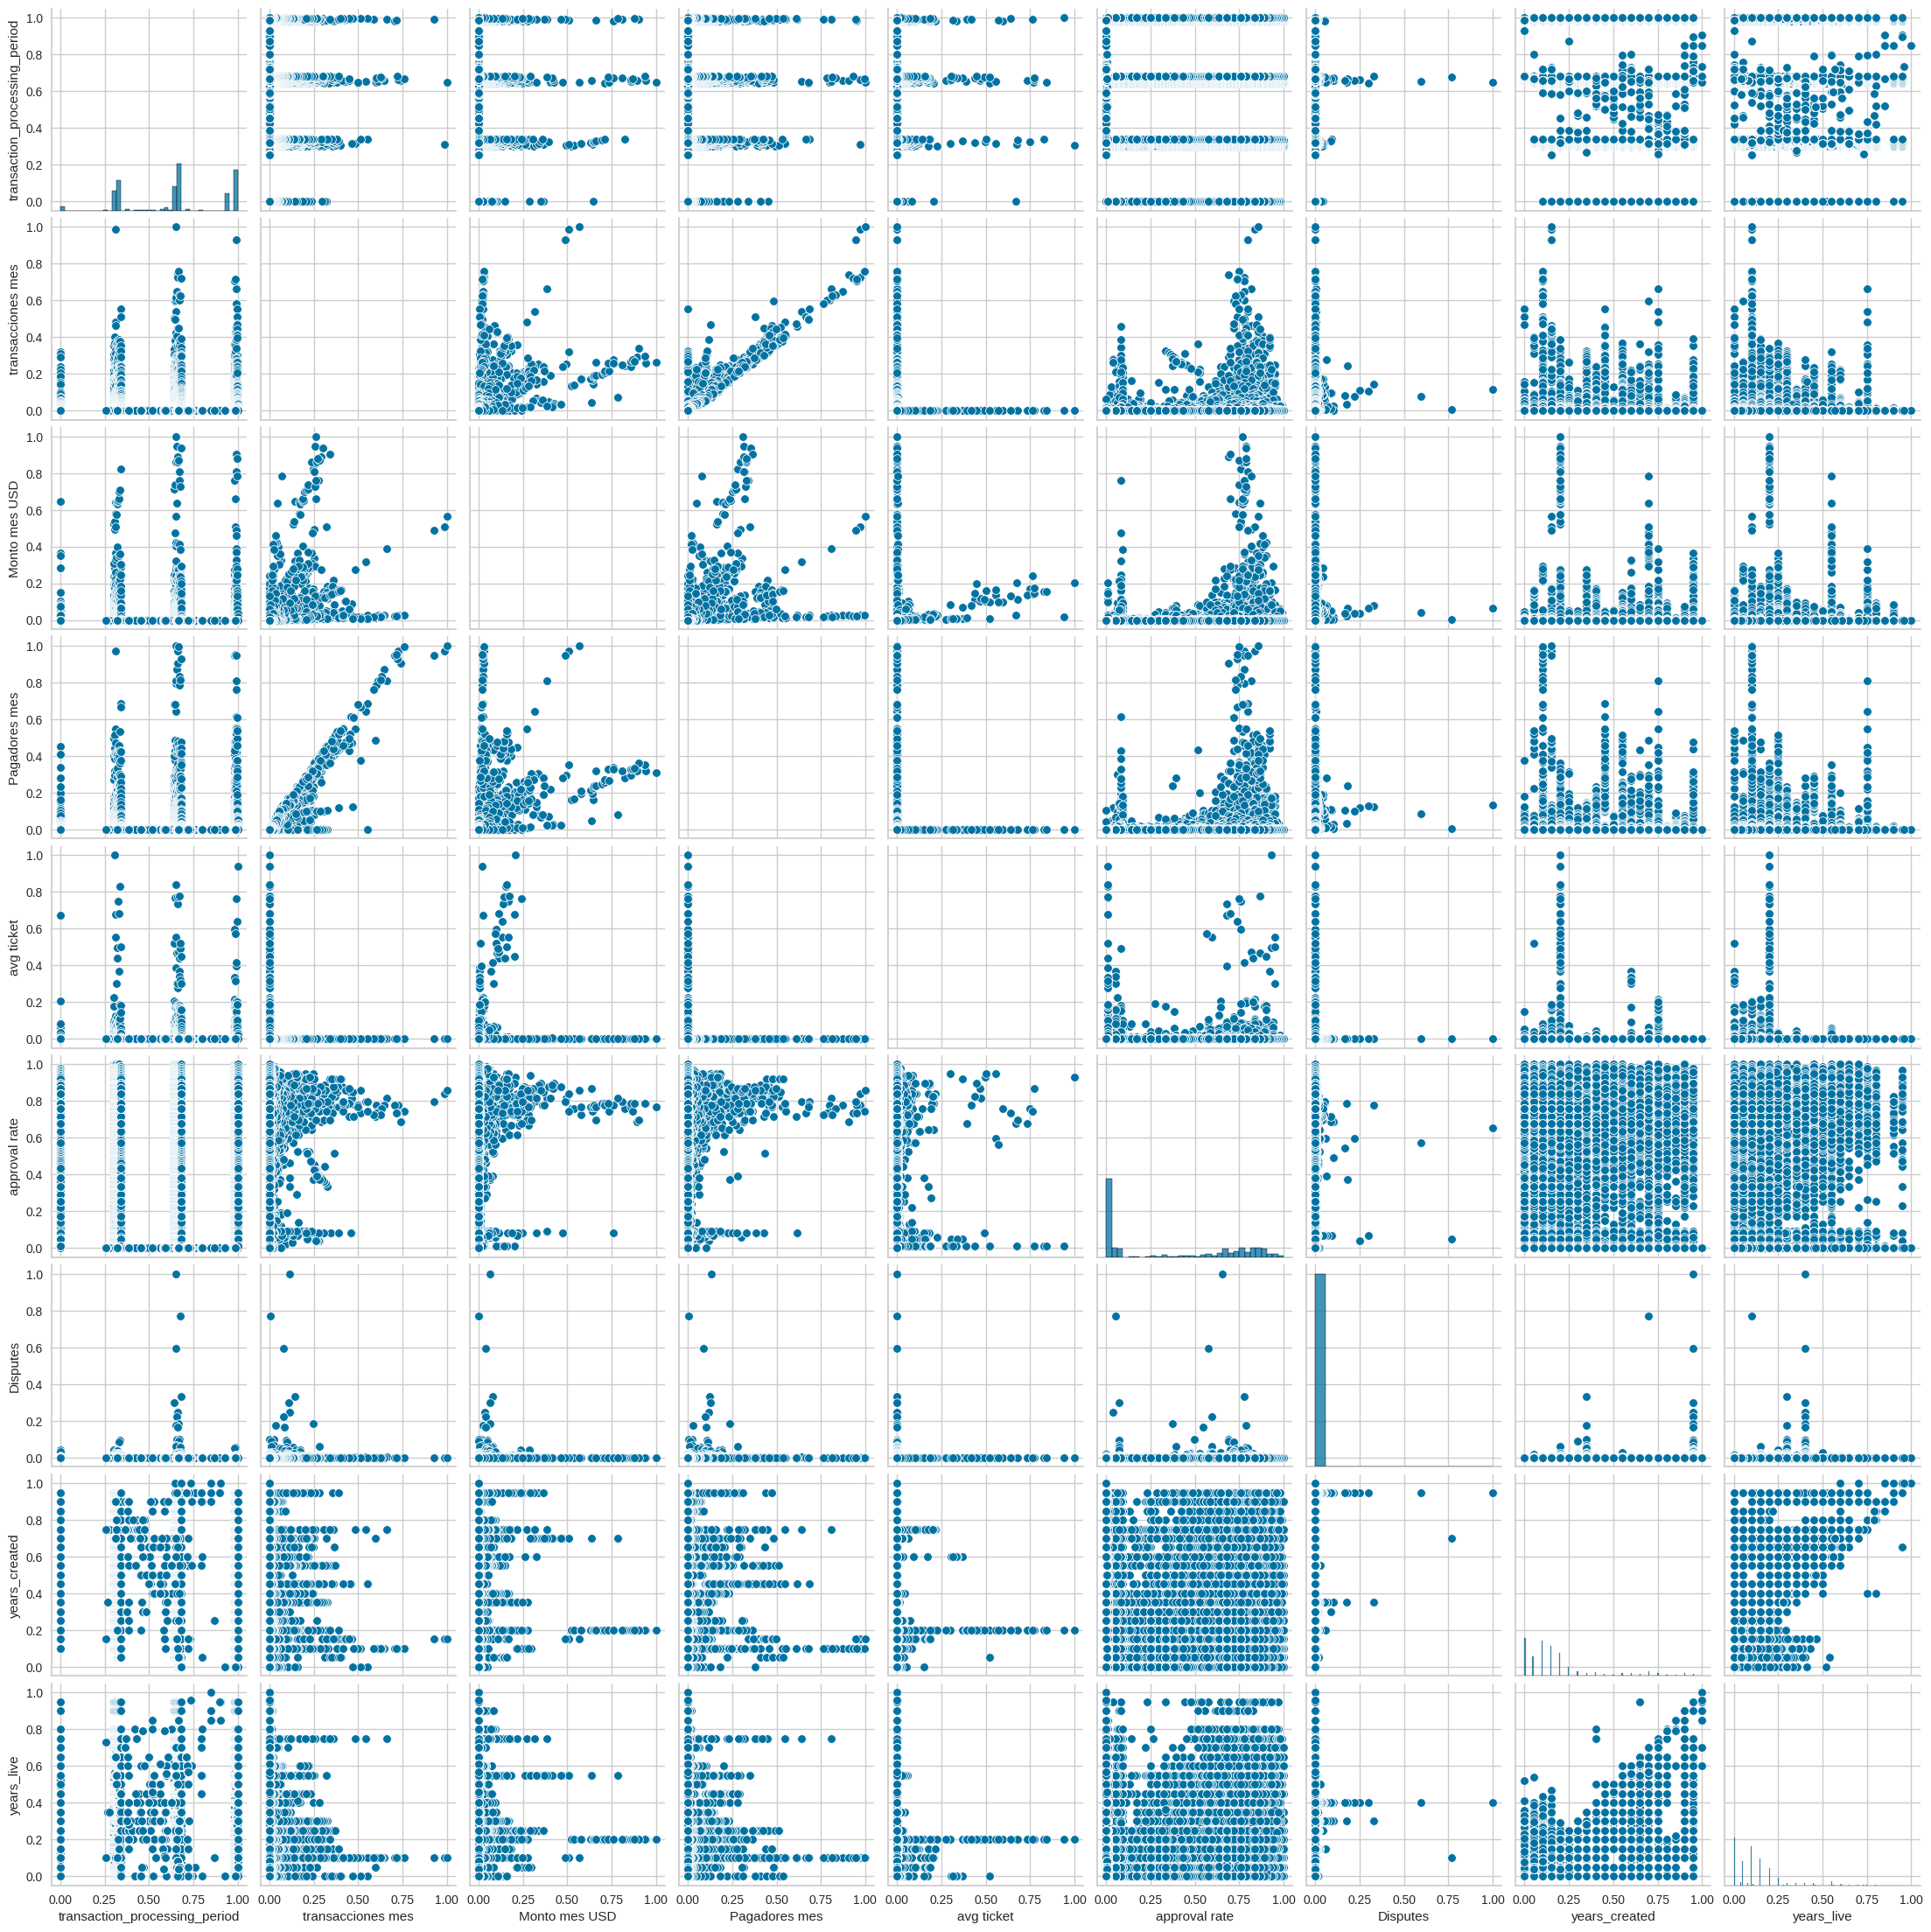

In [32]:
#Visualización de las variables numéricas
sns.pairplot(com_num_imp_minmax)
plt.show()

### Dataframe categórico

In [33]:
#Dataset categórico
comercios_cat = comercios_df.drop(columns_num, axis=1)
display(comercios_cat)

,merchant_address_country,Sitios activos,merchant_classification,merchant_is_iata_travelagency,merchant_enabled,site_classification,active_status,agrupación_mcc
0,CO,1,A+,0,Activo,Recaudo,0,Miscelaneas
1,CO,1,A+,0,Activo,Recaudo,1,Miscelaneas
2,CO,1,A+,0,Activo,Recaudo,0,Miscelaneas
3,CO,1,A+,0,Activo,E-Commerce,1,Miscelaneas
4,CO,1,A+,0,Activo,Recaudo,0,Miscelaneas
...,...,...,...,...,...,...,...,...
108507,UY,1,N,0,Activo,Recaudo,0,Textil
108508,UY,1,N,0,Activo,Recaudo,0,Miscelaneas
108509,UY,1,N,0,Activo,Recaudo,0,Minoristas
108510,UY,1,N,0,Activo,Recaudo,0,Servicios profesionales y membresías


In [34]:
#Verificamos que no hayan carácteres especiales
for category in comercios_cat.columns:
  print(category)
  print('\n')
  display(comercios_cat[category].astype('category'))
  print('\n')
  print(comercios_cat[category].unique())
  print('\n')

merchant_address_country




0         CO
1         CO
2         CO
3         CO
4         CO
          ..
108507    UY
108508    UY
108509    UY
108510    UY
108511    UY
Name: merchant_address_country, Length: 108512, dtype: category
Categories (10, object): ['BZ', 'CL', 'CO', 'CR', ..., 'HN', 'PA', 'PR', 'UY']



['CO' 'EC' 'CR' 'PA' 'CL' 'PR' 'BZ' 'HN' 'UY' 'CW']


Sitios activos




0         1
1         1
2         1
3         1
4         1
         ..
108507    1
108508    1
108509    1
108510    1
108511    1
Name: Sitios activos, Length: 108512, dtype: category
Categories (2, int64): [0, 1]



[1 0]


merchant_classification




0         A+
1         A+
2         A+
3         A+
4         A+
          ..
108507     N
108508     N
108509     N
108510     N
108511     N
Name: merchant_classification, Length: 108512, dtype: category
Categories (6, object): ['A', 'A+', 'B', 'B+', 'C', 'N']



['A+' 'B+' 'B' 'C' 'A' 'N']


merchant_is_iata_travelagency




0         0
1         0
2         0
3         0
4         0
         ..
108507    0
108508    0
108509    0
108510    0
108511    0
Name: merchant_is_iata_travelagency, Length: 108512, dtype: category
Categories (2, int64): [0, 1]



[0 1]


merchant_enabled




0         Activo
1         Activo
2         Activo
3         Activo
4         Activo
           ...  
108507    Activo
108508    Activo
108509    Activo
108510    Activo
108511    Activo
Name: merchant_enabled, Length: 108512, dtype: category
Categories (2, object): ['Activo', 'Inactivo']



['Activo' 'Inactivo']


site_classification




0            Recaudo
1            Recaudo
2            Recaudo
3         E-Commerce
4            Recaudo
             ...    
108507       Recaudo
108508       Recaudo
108509       Recaudo
108510       Recaudo
108511       Recaudo
Name: site_classification, Length: 108512, dtype: category
Categories (2, object): ['E-Commerce', 'Recaudo']



['Recaudo' 'E-Commerce' nan]


active_status




0         0
1         1
2         0
3         1
4         0
         ..
108507    0
108508    0
108509    0
108510    0
108511    0
Name: active_status, Length: 108512, dtype: category
Categories (2, int64): [0, 1]



[0 1]


agrupación_mcc




0                                  Miscelaneas
1                                  Miscelaneas
2                                  Miscelaneas
3                                  Miscelaneas
4                                  Miscelaneas
                          ...                 
108507                                  Textil
108508                             Miscelaneas
108509                              Minoristas
108510    Servicios profesionales y membresías
108511                                  Textil
Name: agrupación_mcc, Length: 108512, dtype: category
Categories (13, object): ['Agricultura' < 'Servicios contractuales' < 'Aerolíneas' <
                          'Alquiler de vehículos' ... 'Miscelaneas' < 'Negocios' <
                          'Servicios profesionales y membresías' < 'Gubernamentales']



['Miscelaneas', 'Textil', 'Negocios', 'Servicios de utilidad', 'Minoristas', ..., 'Servicios profesionales y membresías', 'Agricultura', 'Servicios contractuales', 'Aerolíneas', 'Alojamiento']
Length: 13
Categories (13, object): ['Agricultura' < 'Servicios contractuales' < 'Aerolíneas' <
                          'Alquiler de vehículos' ... 'Miscelaneas' < 'Negocios' <
                          'Servicios profesionales y membresías' < 'Gubernamentales']




In [35]:
#Observamos el tamaño y datos nulos de nuestro dataframe númerico
comercios_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108512 entries, 0 to 108511
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   merchant_address_country       108512 non-null  object  
 1   Sitios activos                 108512 non-null  int64   
 2   merchant_classification        108512 non-null  object  
 3   merchant_is_iata_travelagency  108512 non-null  int64   
 4   merchant_enabled               108512 non-null  object  
 5   site_classification            107157 non-null  object  
 6   active_status                  108512 non-null  int64   
 7   agrupación_mcc                 77866 non-null   category
dtypes: category(1), int64(3), object(4)
memory usage: 5.9+ MB


In [36]:
#Identificamos el porcentaje de datos nulos por columna en el DataFrame númerico
for columna in comercios_cat.columns:
  porcentaje=100*comercios_cat[columna].isna().sum()/len(comercios_cat[columna])
  print(f'El porcentaje de datos faltantes en la columna {columna} es de {round(porcentaje,2)}%')

El porcentaje de datos faltantes en la columna merchant_address_country es de 0.0%
El porcentaje de datos faltantes en la columna Sitios activos es de 0.0%
El porcentaje de datos faltantes en la columna merchant_classification es de 0.0%
El porcentaje de datos faltantes en la columna merchant_is_iata_travelagency es de 0.0%
El porcentaje de datos faltantes en la columna merchant_enabled es de 0.0%
El porcentaje de datos faltantes en la columna site_classification es de 1.25%
El porcentaje de datos faltantes en la columna active_status es de 0.0%
El porcentaje de datos faltantes en la columna agrupación_mcc es de 28.24%


**Imputación datos categóricos**

Luego de la limpieza y la identificación de datos nulos, se procede con la imputación simple usando la estrategía del "más frecuente" o moda.

In [37]:
#Imputación simple
imputador = SimpleImputer(missing_values = np.nan, strategy= 'most_frequent') # Rellena los datos NaN por medio del cálculo de los valores más frecuentes
imputador.fit(comercios_cat)
comercios_cat_imp = imputador.transform(comercios_cat)
categorias_cat = comercios_cat.columns
comercios_cat_imp = pd.DataFrame(comercios_cat_imp, columns = categorias_cat)
display(comercios_cat_imp)

,merchant_address_country,Sitios activos,merchant_classification,merchant_is_iata_travelagency,merchant_enabled,site_classification,active_status,agrupación_mcc
0,CO,1,A+,0,Activo,Recaudo,0,Miscelaneas
1,CO,1,A+,0,Activo,Recaudo,1,Miscelaneas
2,CO,1,A+,0,Activo,Recaudo,0,Miscelaneas
3,CO,1,A+,0,Activo,E-Commerce,1,Miscelaneas
4,CO,1,A+,0,Activo,Recaudo,0,Miscelaneas
...,...,...,...,...,...,...,...,...
108507,UY,1,N,0,Activo,Recaudo,0,Textil
108508,UY,1,N,0,Activo,Recaudo,0,Miscelaneas
108509,UY,1,N,0,Activo,Recaudo,0,Minoristas
108510,UY,1,N,0,Activo,Recaudo,0,Servicios profesionales y membresías


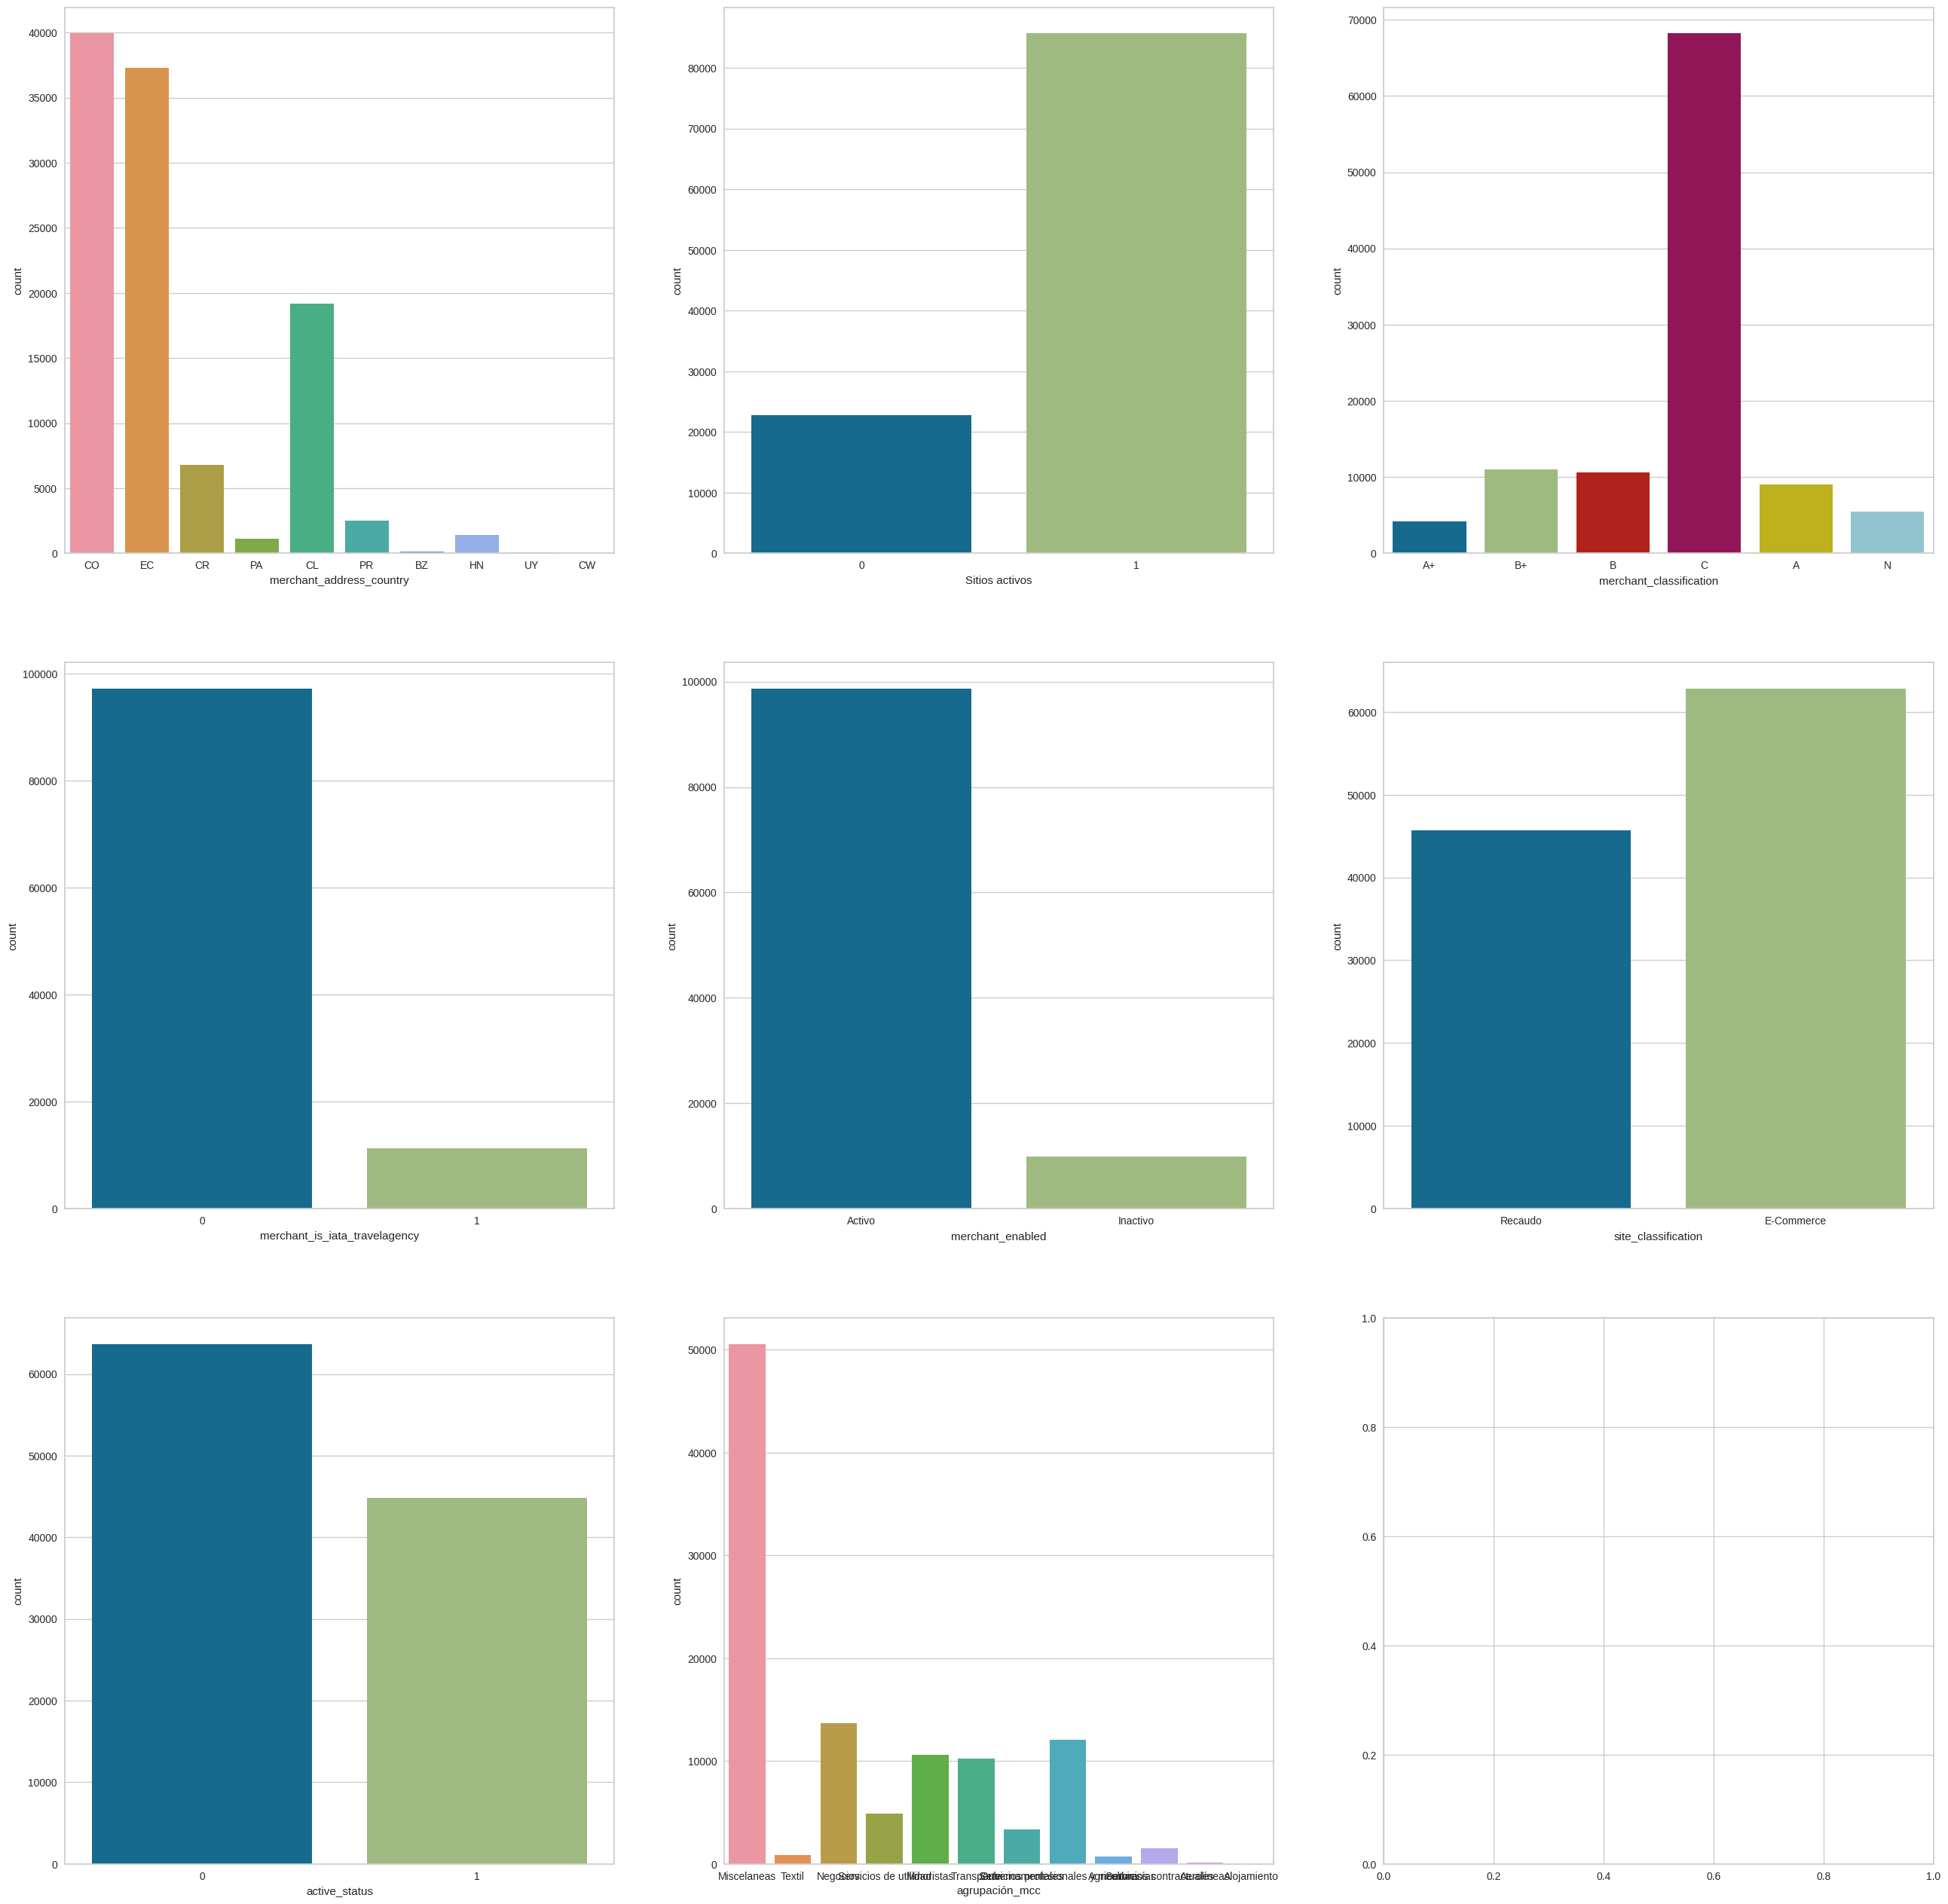

In [38]:
#Visualización de las frecuencias de instancias de las variables categóricas
plot_multiples_graficas(comercios_cat_imp,comercios_cat_imp.columns, 3, 3, 'c', None, (32,32))

In [39]:
comercios_cat_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108512 entries, 0 to 108511
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   merchant_address_country       108512 non-null  object
 1   Sitios activos                 108512 non-null  object
 2   merchant_classification        108512 non-null  object
 3   merchant_is_iata_travelagency  108512 non-null  object
 4   merchant_enabled               108512 non-null  object
 5   site_classification            108512 non-null  object
 6   active_status                  108512 non-null  object
 7   agrupación_mcc                 108512 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB


**Creación de variables dummies**

Con el fin de continuar con la preparación de los datos y fácilitar el modelado, se procede a generar las variables dummies a partir de las variables categóricas. Sin embargo, para evitar un aumento de dimensionalidad mayor, se cambia el tipo de las variables `"Sitios activos"`, `"merchant_is_iata_travelagency"` y `"active_status"` a enteros.

Para la variable `"merchant_classification"` se decide realizar una codificación de etiquetas aprovechando su caracter ordinal.

In [40]:
#Cambio de tipo a entero
comercios_cat_imp['Sitios activos'] = comercios_cat_imp['Sitios activos'].astype(int)
comercios_cat_imp['merchant_is_iata_travelagency'] = comercios_cat_imp['merchant_is_iata_travelagency'].astype(int)
comercios_cat_imp['active_status'] = comercios_cat_imp['active_status'].astype(int)

In [41]:
#Codificación de etiquetas para la variable merchant_classification
mapeo = {'A+': 6, 'A': 5, 'B+': 4, 'B': 3, 'C': 2, 'N': 1}
comercios_cat_imp['merchant_classification'] = comercios_cat_imp['merchant_classification'].map(mapeo).astype(int)

In [42]:
# Aplicación de la función de get_dummies
comercios_cat_imp_dum =pd.get_dummies(comercios_cat_imp)
comercios_cat_imp_dum.head()

,Sitios activos,merchant_classification,merchant_is_iata_travelagency,active_status,merchant_address_country_BZ,merchant_address_country_CL,merchant_address_country_CO,merchant_address_country_CR,merchant_address_country_CW,merchant_address_country_EC,merchant_address_country_HN,merchant_address_country_PA,merchant_address_country_PR,merchant_address_country_UY,merchant_enabled_Activo,merchant_enabled_Inactivo,site_classification_E-Commerce,site_classification_Recaudo,agrupación_mcc_Aerolíneas,agrupación_mcc_Agricultura,agrupación_mcc_Alojamiento,agrupación_mcc_Gubernamentales,agrupación_mcc_Minoristas,agrupación_mcc_Miscelaneas,agrupación_mcc_Negocios,agrupación_mcc_Servicios contractuales,agrupación_mcc_Servicios de utilidad,agrupación_mcc_Servicios profesionales y membresías,agrupación_mcc_Textil,agrupación_mcc_Transporte
0,1,6,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,1,6,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,1,6,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,1,6,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,6,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [43]:
comercios_cat_imp_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108512 entries, 0 to 108511
Data columns (total 30 columns):
 #   Column                                               Non-Null Count   Dtype
---  ------                                               --------------   -----
 0   Sitios activos                                       108512 non-null  int64
 1   merchant_classification                              108512 non-null  int64
 2   merchant_is_iata_travelagency                        108512 non-null  int64
 3   active_status                                        108512 non-null  int64
 4   merchant_address_country_BZ                          108512 non-null  uint8
 5   merchant_address_country_CL                          108512 non-null  uint8
 6   merchant_address_country_CO                          108512 non-null  uint8
 7   merchant_address_country_CR                          108512 non-null  uint8
 8   merchant_address_country_CW                          108512 non-null  uint

**Escalamiento datos categóricos**

In [44]:
MinMax = MinMaxScaler(copy=True, feature_range=(0, 1)) # Método MinMax con valores entre 0 y 1
nombres = comercios_cat_imp_dum.columns
com_cat_imp_minmax = MinMax.fit_transform(comercios_cat_imp_dum) # Transformación de los nuevos datos con una escala MinMax
com_cat_imp_minmax = pd.DataFrame(com_cat_imp_minmax, columns = nombres)

In [45]:
com_cat_imp_minmax.describe()

,Sitios activos,merchant_classification,merchant_is_iata_travelagency,active_status,merchant_address_country_BZ,merchant_address_country_CL,merchant_address_country_CO,merchant_address_country_CR,merchant_address_country_CW,merchant_address_country_EC,merchant_address_country_HN,merchant_address_country_PA,merchant_address_country_PR,merchant_address_country_UY,merchant_enabled_Activo,merchant_enabled_Inactivo,site_classification_E-Commerce,site_classification_Recaudo,agrupación_mcc_Aerolíneas,agrupación_mcc_Agricultura,agrupación_mcc_Alojamiento,agrupación_mcc_Gubernamentales,agrupación_mcc_Minoristas,agrupación_mcc_Miscelaneas,agrupación_mcc_Negocios,agrupación_mcc_Servicios contractuales,agrupación_mcc_Servicios de utilidad,agrupación_mcc_Servicios profesionales y membresías,agrupación_mcc_Textil,agrupación_mcc_Transporte
count,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000,108512.000000
mean,0.789738,0.330974,0.104394,0.412968,0.001198,0.176911,0.368088,0.062657,0.000009,0.343879,0.013178,0.010395,0.023131,0.000553,0.909365,0.090635,0.578922,0.421078,0.001447,0.006340,0.000037,0.030771,0.097455,0.466004,0.125958,0.013685,0.045230,0.111149,0.007686,0.094238
std,0.407497,0.244373,0.305772,0.492369,0.034592,0.381595,0.482288,0.242346,0.003036,0.475003,0.114038,0.101426,0.150320,0.023508,0.287091,0.287091,0.493734,0.493734,0.038010,0.079374,0.006071,0.172697,0.296577,0.498845,0.331804,0.116181,0.207809,0.314318,0.087331,0.292161
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.400000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Tratamiento de datos atípicos

Como ya se tienen los datos númericos escalados, se procede a identificar y eliminar atípicos con el método LOF.

In [46]:
#Unimos los dataframes para borrar atípicos
comercios_concat = pd.concat([com_num_imp_minmax,com_cat_imp_minmax],axis=1)

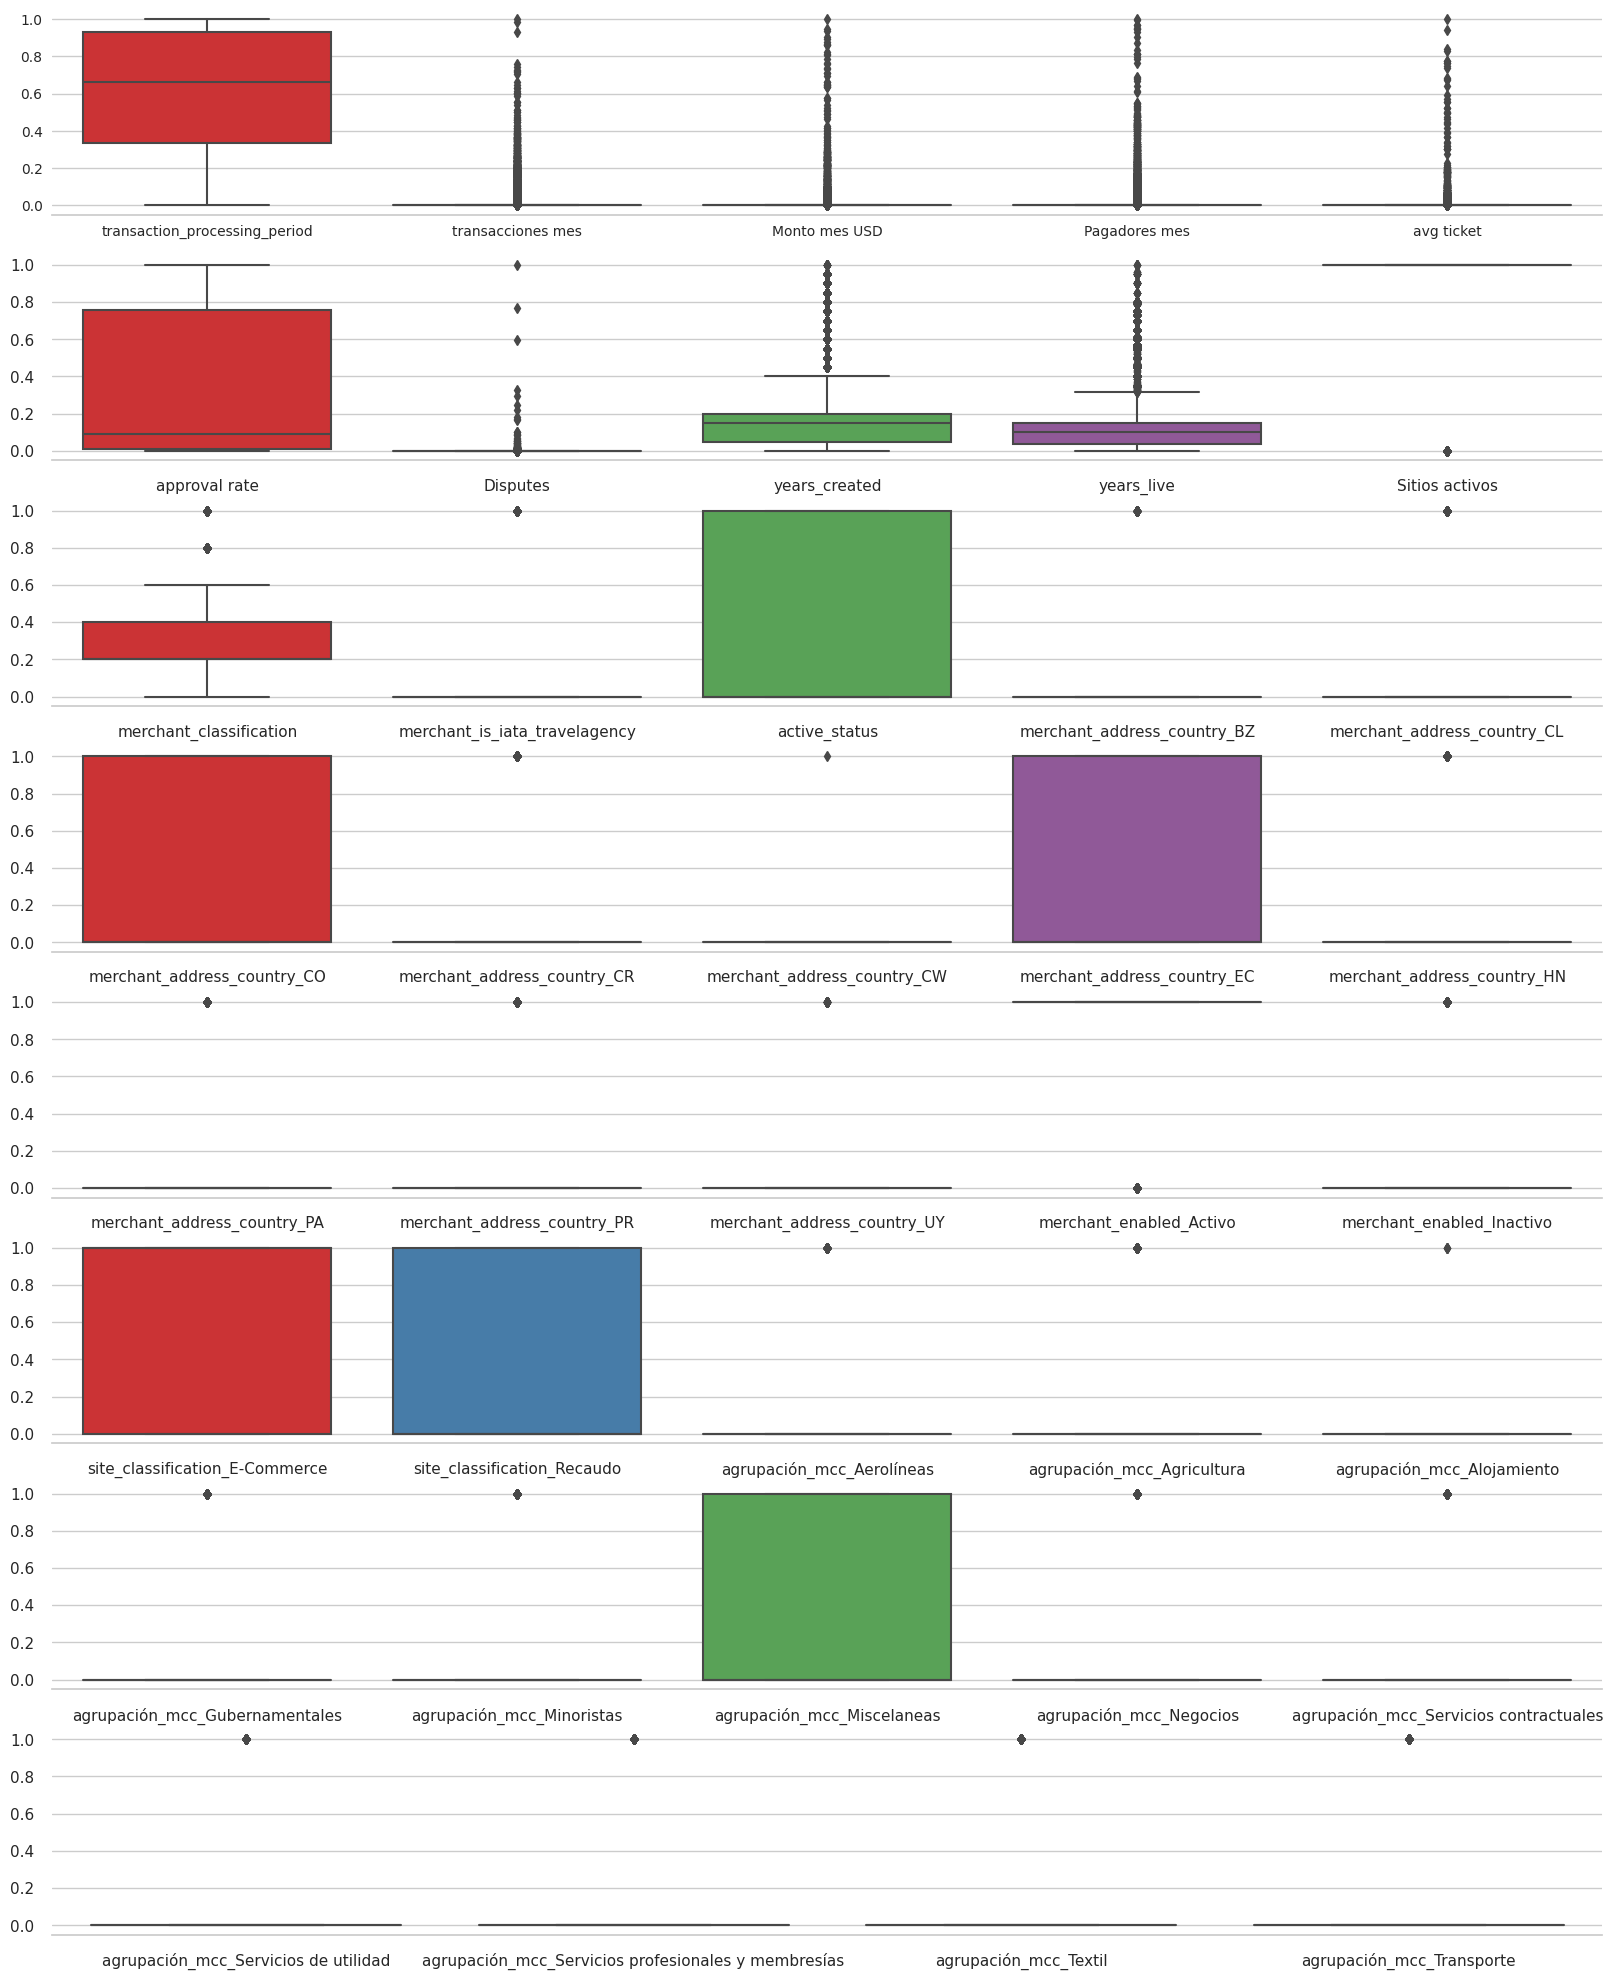

In [47]:
#Visualizamos los datos atípicos

plt.rcParams["figure.figsize"] = (20,25)

plt.subplot(8,1,1)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_concat.iloc[:,:5], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,2)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_concat.iloc[:,5:10], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,3)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_concat.iloc[:,10:15], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,4)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_concat.iloc[:,15:20], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,5)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_concat.iloc[:,20:25], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,6)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_concat.iloc[:,25:30], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,7)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_concat.iloc[:,30:35], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,8)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_concat.iloc[:,35:45], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

In [48]:
#Eliminamos los datos atípicos de forma controlada utilizando el algoritmo LOF que se basa en vecinos cercanos.

LOF = LocalOutlierFactor(n_neighbors = 5, algorithm = 'auto', contamination = 0.05, metric = 'euclidean')
Filtrado = LOF.fit_predict(com_num_imp_minmax)
NOF = LOF.negative_outlier_factor_
radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min())
ground_truth = np.ones(len(com_num_imp_minmax), dtype = int)
n_errors = (Filtrado != ground_truth).sum()

In [49]:
print("Detección: ", Filtrado)
print("Factores atípicos negativos: ", NOF)
print("Número de muestras o filas con datos atípicos: ", n_errors)

Detección:  [ 1 -1  1 ...  1  1  1]
Factores atípicos negativos:  [-2.29111297 -6.53419368 -2.4348161  ... -1.         -1.
 -1.        ]
Número de muestras o filas con datos atípicos:  5426


In [50]:
pos = np.where(Filtrado == ground_truth) # Se identifican en que muestras o filas de nuestra base de datos hay presencia de datos atípicos
pos = np.asarray(pos)
pos = np.hstack(pos)
comercios_NO = comercios_concat.loc[pos, :]
print("Número de muestras sin outilers:", comercios_NO.shape[0])

Número de muestras sin outilers: 103086


In [51]:
#Reseteamos los indices del dataframe
comercios_NO = comercios_NO.reset_index(drop = True)

In [52]:
display(comercios_NO)

,transaction_processing_period,transacciones mes,Monto mes USD,Pagadores mes,avg ticket,approval rate,Disputes,years_created,years_live,Sitios activos,merchant_classification,merchant_is_iata_travelagency,active_status,merchant_address_country_BZ,merchant_address_country_CL,merchant_address_country_CO,merchant_address_country_CR,merchant_address_country_CW,merchant_address_country_EC,merchant_address_country_HN,merchant_address_country_PA,merchant_address_country_PR,merchant_address_country_UY,merchant_enabled_Activo,merchant_enabled_Inactivo,site_classification_E-Commerce,site_classification_Recaudo,agrupación_mcc_Aerolíneas,agrupación_mcc_Agricultura,agrupación_mcc_Alojamiento,agrupación_mcc_Gubernamentales,agrupación_mcc_Minoristas,agrupación_mcc_Miscelaneas,agrupación_mcc_Negocios,agrupación_mcc_Servicios contractuales,agrupación_mcc_Servicios de utilidad,agrupación_mcc_Servicios profesionales y membresías,agrupación_mcc_Textil,agrupación_mcc_Transporte
0,0.649660,0.114645,0.064311,0.131414,0.000126,0.656566,1.000000,0.95,0.4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.653061,0.078840,0.039133,0.086418,0.000128,0.575758,0.594050,0.95,0.4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.680272,0.145362,0.080771,0.121182,0.000105,0.777778,0.330134,0.35,0.3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.656463,0.079819,0.038408,0.098840,0.000120,0.595960,0.220729,0.95,0.4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.666667,0.246294,0.066345,0.236294,0.000107,0.373737,0.182342,0.95,0.4,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,0.986395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103082,0.986395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
103083,0.986395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103084,0.986395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


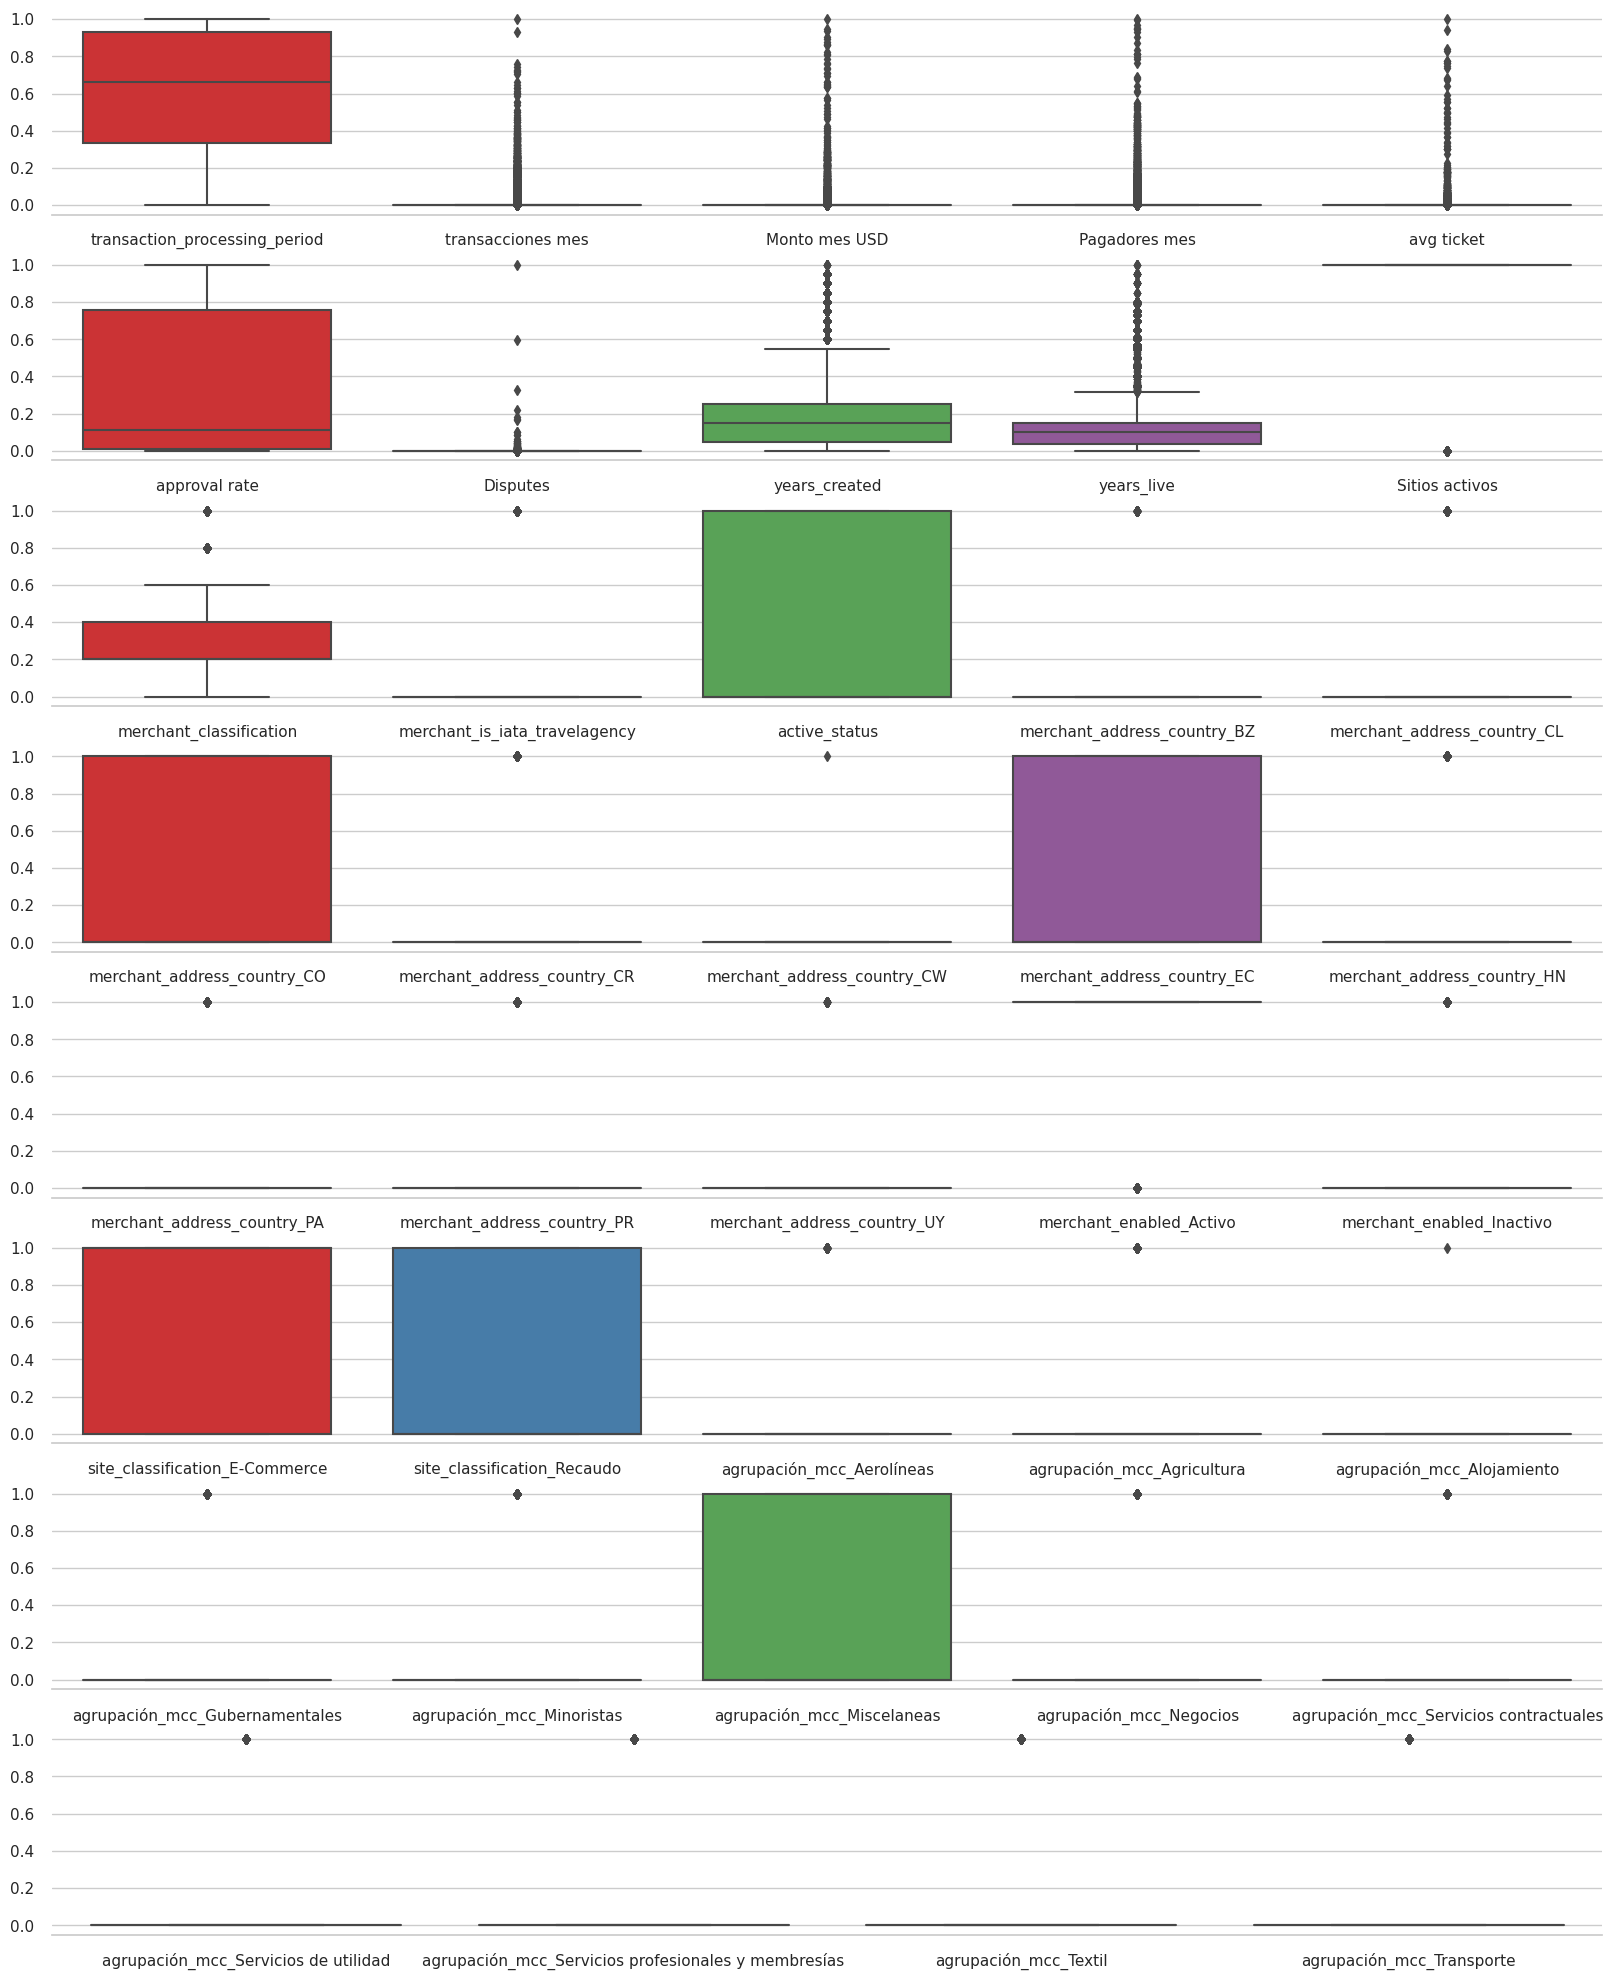

In [53]:
# Visualizamos nuevamente atípicos luego del tratamiento

plt.rcParams["figure.figsize"] = (20,25)

plt.subplot(8,1,1)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_NO.iloc[:,:5], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,2)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_NO.iloc[:,5:10], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,3)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_NO.iloc[:,10:15], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,4)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_NO.iloc[:,15:20], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,5)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_NO.iloc[:,20:25], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,6)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_NO.iloc[:,25:30], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,7)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_NO.iloc[:,30:35], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

plt.subplot(8,1,8)
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = comercios_NO.iloc[:,35:45], linewidth = 1.5, palette="Set1", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

In [54]:
comercios_NO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103086 entries, 0 to 103085
Data columns (total 39 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   transaction_processing_period                        103086 non-null  float64
 1   transacciones mes                                    103086 non-null  float64
 2   Monto mes USD                                        103086 non-null  float64
 3   Pagadores mes                                        103086 non-null  float64
 4   avg ticket                                           103086 non-null  float64
 5   approval rate                                        103086 non-null  float64
 6   Disputes                                             103086 non-null  float64
 7   years_created                                        103086 non-null  float64
 8   years_live                                           1

# Análisis cluster

Con los datos ya imputados, normalizados y con un tratamiento controlado de datos atípicos, procedemos a realizar nuestro análisis cluster para segmentar los clientes de Evertec Placetopay S.A.S

## Búsqueda del número óptimo de clusters con el algoritmo KMeans

Como no conocemos el número de agrupaciones idóneo para nuestro modelo no supervisado, iniciaremos con la exploración y la identificación de ese número de grupos óptimo que nos garantice una mayor separabilidad y compactación. Para ello, nos apoyaremos del diagrama de codo.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

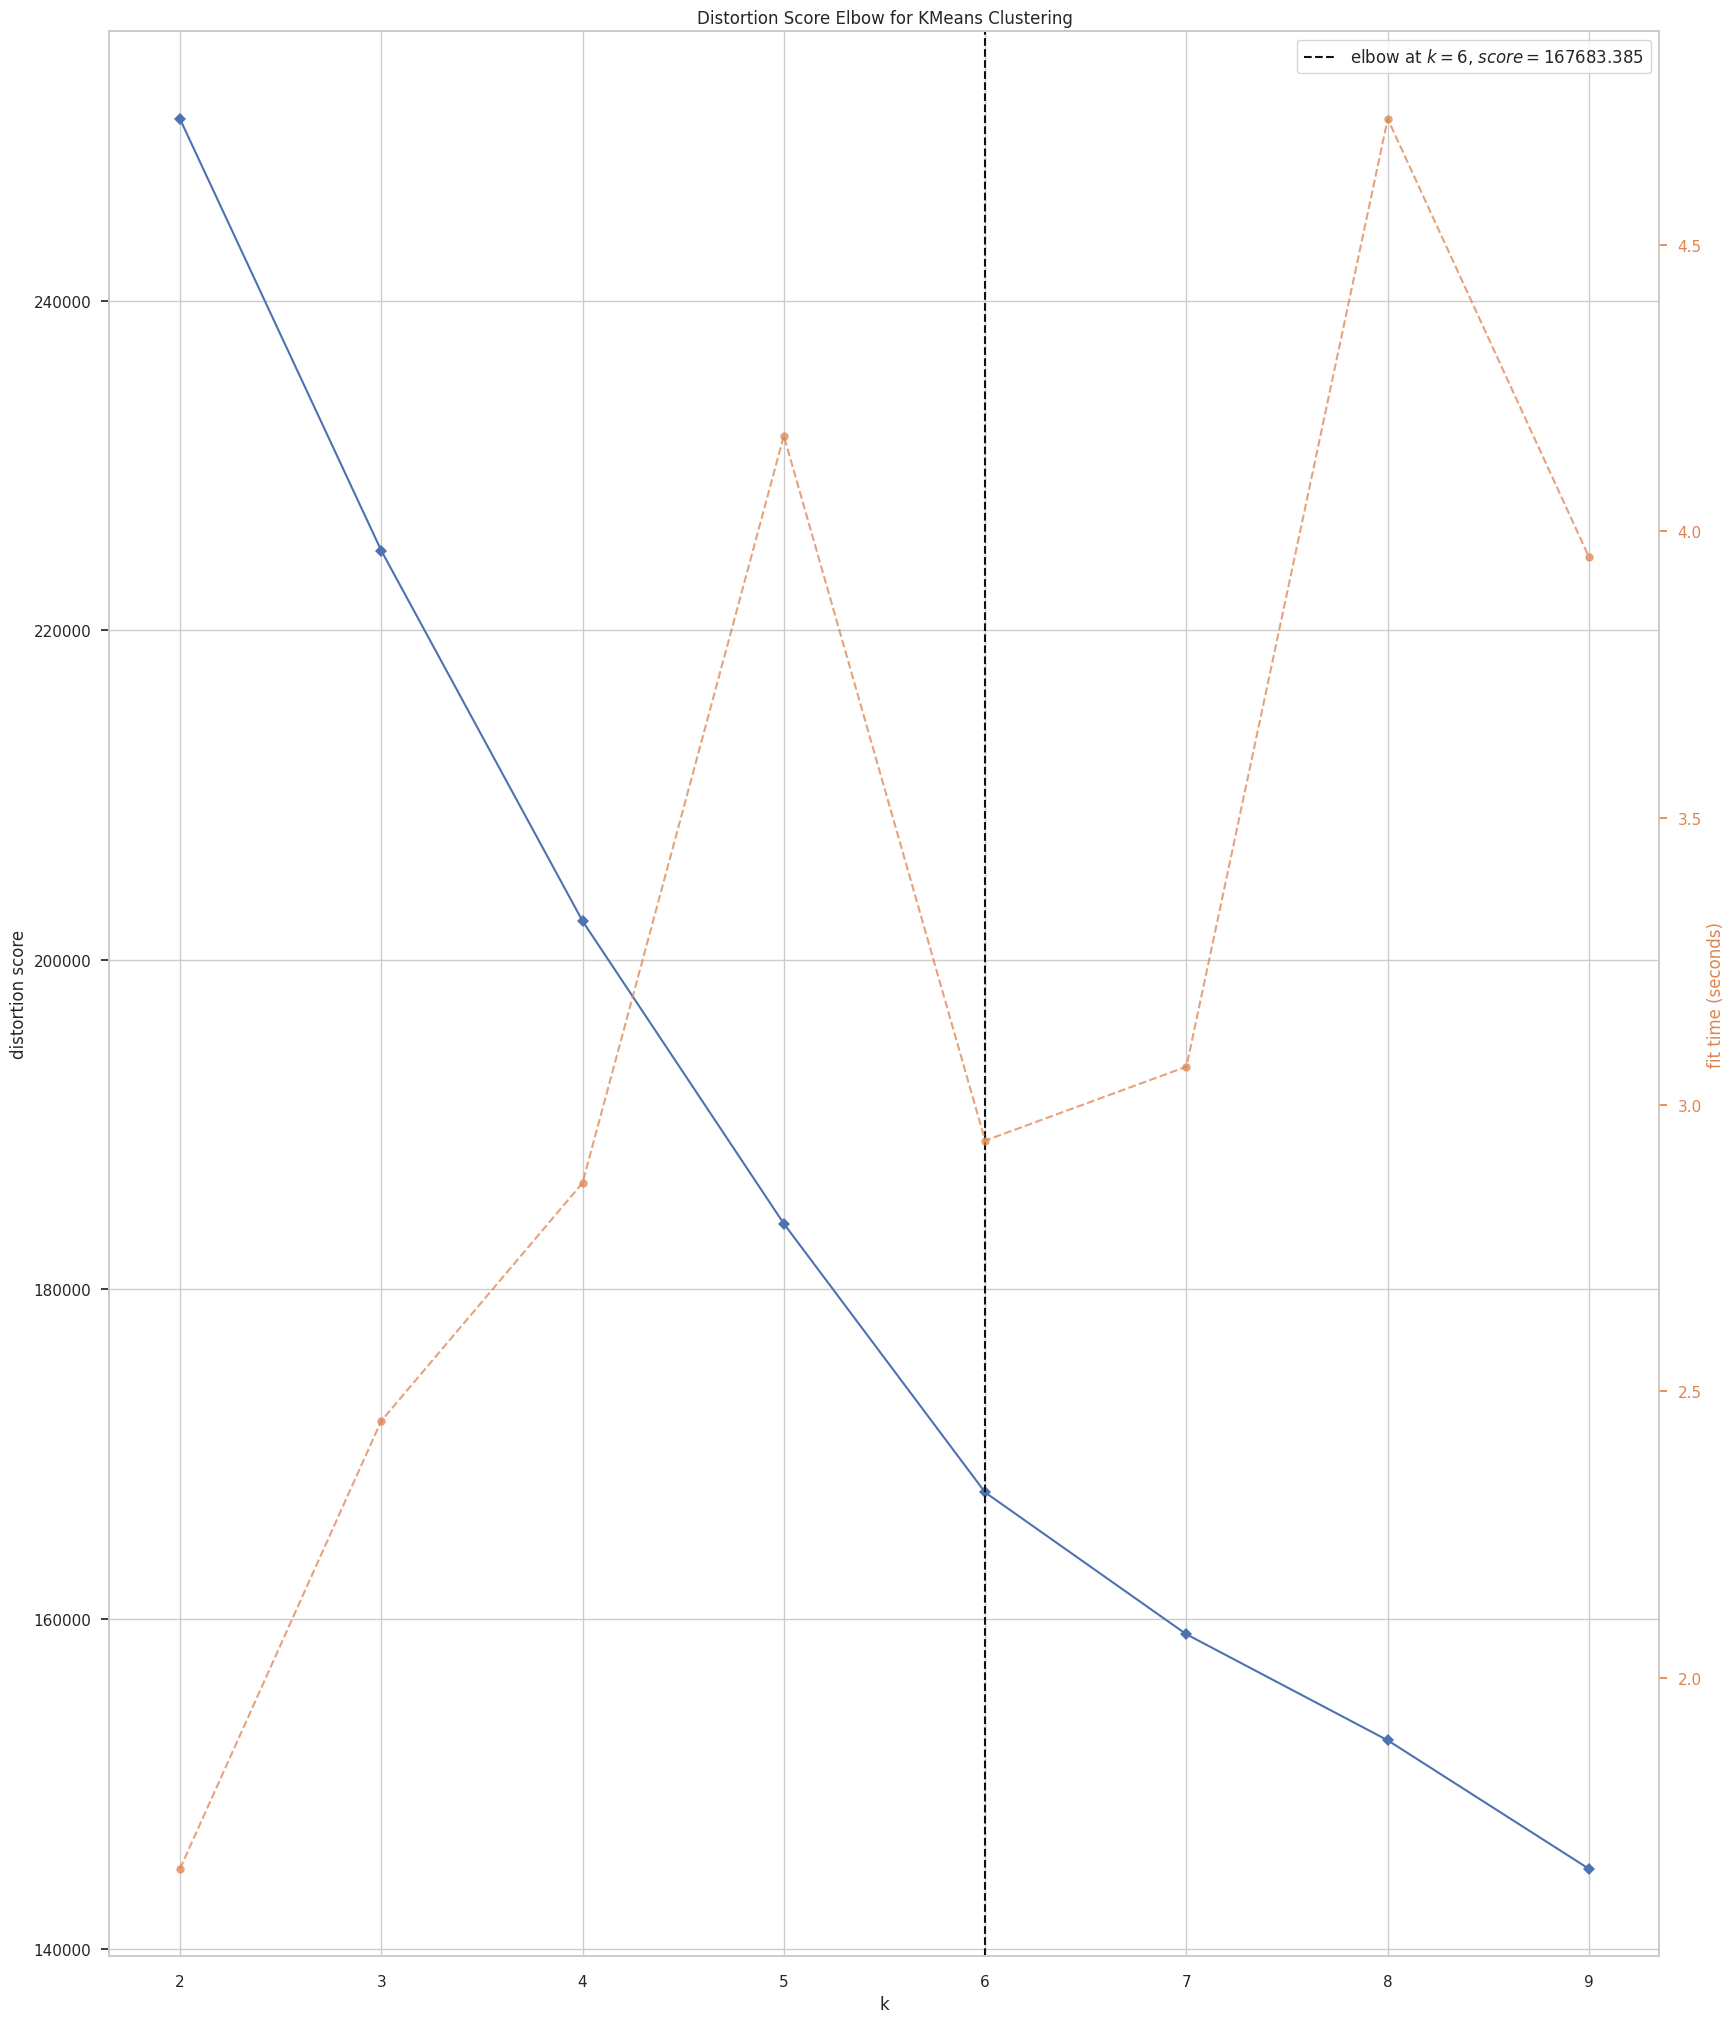

In [55]:
#DIAGRAMA DE CODO
error = 1e-4
max_iteraciones = 5000
fig, ax = plt.subplots()
Codito = KElbowVisualizer(KMeans(max_iter = max_iteraciones, tol = error, random_state = 17),
                              k = (2,10), ax = ax)
Codito.fit(comercios_NO)
ax.set_xticks(range(2,10))
Codito.show()
plt.show()

In [56]:
Numero_Clusters = 6
error = 1e-4
max_iteraciones = 5000

Modelo_Kmeans_X = KMeans(n_clusters = Numero_Clusters, max_iter = max_iteraciones,
                       tol = error,random_state = 17)
Modelo_Kmeans_X.fit(comercios_NO)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(max_iter=5000, n_clusters=6, random_state=17)

In [57]:
Clases_X = Modelo_Kmeans_X.labels_

In [58]:
Clases_X

array([4, 4, 0, ..., 1, 1, 1], dtype=int32)

In [59]:
centros_X = Modelo_Kmeans_X.cluster_centers_

In [60]:
centros_X.shape

(6, 39)

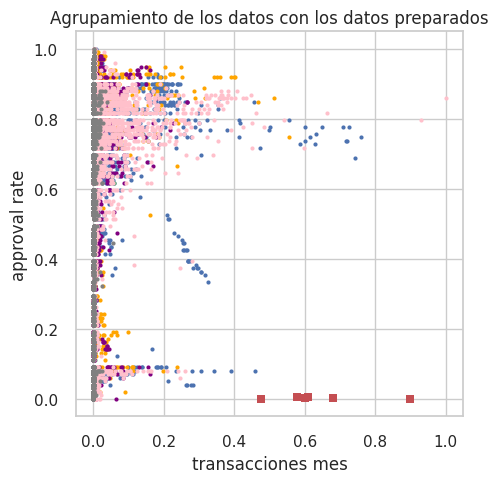

In [61]:
x_1 = comercios_NO['transacciones mes']
x_2 = comercios_NO['approval rate']


colors = ["b", "orange","g","purple","pink","gray","red"]
fig = plt.figure(figsize = (5,5))

for j in range(Numero_Clusters):
    plt.plot(x_1[Clases_X == j], x_2[Clases_X == j], '.', color = colors[j])

for pt in centros_X:
    plt.plot(pt[0],pt[1],'rs') # r = rojo; s = square

plt.xlabel("transacciones mes")
plt.ylabel("approval rate")
plt.title("Agrupamiento de los datos con los datos preparados")
plt.show()

In [62]:
Tabla_Resultados = np.array([silhouette_score(comercios_NO, Clases_X),
                   calinski_harabasz_score(comercios_NO, Clases_X),
                   davies_bouldin_score(comercios_NO, Clases_X)])

In [63]:
Tabla_Resultados_DF = pd.DataFrame([Tabla_Resultados], columns=['Silueta', 'CH', 'DB'], index=['Base sin reducción de dimensionalidad'])

display(Tabla_Resultados_DF)

,Silueta,CH,DB
Base sin reducción de dimensionalidad,0.224741,16682.741996,1.694246


## Integración del vector de clases con el dataframe

Se procede a anexar el vector de clases obtenido con kmeans al dataframe.

In [64]:
# Primero se crea una copia
comercios_clases = comercios_NO.copy()

# Se Agregar el vector de clases como una nueva columna al dataset
comercios_clases['Clases'] = Clases_X

comercios_clases['Clases'].value_counts()

1    20214
3    19673
0    19012
4    17765
2    17060
5     9362
Name: Clases, dtype: int64

In [65]:
comercios_clases.head(50)

,transaction_processing_period,transacciones mes,Monto mes USD,Pagadores mes,avg ticket,approval rate,Disputes,years_created,years_live,Sitios activos,merchant_classification,merchant_is_iata_travelagency,active_status,merchant_address_country_BZ,merchant_address_country_CL,merchant_address_country_CO,merchant_address_country_CR,merchant_address_country_CW,merchant_address_country_EC,merchant_address_country_HN,merchant_address_country_PA,merchant_address_country_PR,merchant_address_country_UY,merchant_enabled_Activo,merchant_enabled_Inactivo,site_classification_E-Commerce,site_classification_Recaudo,agrupación_mcc_Aerolíneas,agrupación_mcc_Agricultura,agrupación_mcc_Alojamiento,agrupación_mcc_Gubernamentales,agrupación_mcc_Minoristas,agrupación_mcc_Miscelaneas,agrupación_mcc_Negocios,agrupación_mcc_Servicios contractuales,agrupación_mcc_Servicios de utilidad,agrupación_mcc_Servicios profesionales y membresías,agrupación_mcc_Textil,agrupación_mcc_Transporte,Clases
0,0.649660,0.114645,0.064311,0.131414,0.000126,0.656566,1.000000,0.95,0.40,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.653061,0.078840,0.039133,0.086418,0.000128,0.575758,0.594050,0.95,0.40,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.680272,0.145362,0.080771,0.121182,0.000105,0.777778,0.330134,0.35,0.30,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.656463,0.079819,0.038408,0.098840,0.000120,0.595960,0.220729,0.95,0.40,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.666667,0.246294,0.066345,0.236294,0.000107,0.373737,0.182342,0.95,0.40,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
5,0.649660,0.034647,0.024164,0.031261,0.000130,0.787879,0.173704,0.35,0.30,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.659864,0.082310,0.038013,0.102574,0.000124,0.545455,0.165067,0.95,0.40,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
7,0.656463,0.027512,0.016331,0.026399,0.000127,0.686869,0.099808,0.35,0.30,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.673469,0.002447,0.000908,0.003075,0.000110,0.494949,0.099808,0.95,0.40,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
9,0.666667,0.009517,0.001482,0.012160,0.000033,0.686869,0.088292,0.30,0.30,1.0,0.6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


# Regresión lineal

Luego de tener una clasificación o etiquetas para clientes de Evertec Placetopay S.A.S según la similitud de sus características, se procede a relizar una predicción de una de las variables de interés para la empresa, en este caso se hará una regresión lineal para la variable **`"Monto mes USD"`**.

Para ello, primero eliminamos dicha variable del dataframe, ya que ésta será nuestra variable objetivo.

In [66]:
# Eliminación de la variable 'Monto mes USD'
comercios_clases = comercios_clases.drop('Monto mes USD', axis=1)


In [67]:
comercios_clases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103086 entries, 0 to 103085
Data columns (total 39 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   transaction_processing_period                        103086 non-null  float64
 1   transacciones mes                                    103086 non-null  float64
 2   Pagadores mes                                        103086 non-null  float64
 3   avg ticket                                           103086 non-null  float64
 4   approval rate                                        103086 non-null  float64
 5   Disputes                                             103086 non-null  float64
 6   years_created                                        103086 non-null  float64
 7   years_live                                           103086 non-null  float64
 8   Sitios activos                                       1

In [69]:
# Primero se deberá hacer una transformación inversa de la escalización de los datos de la variable respuesta
min_value = com_num_imp['Monto mes USD'].min()
max_value = com_num_imp['Monto mes USD'].max()

y_objetivo = comercios_NO['Monto mes USD'] * (max_value - min_value) + min_value

y_objetivo.head()


0    4210319.35
1    2562006.34
2    5287959.05
3    2514485.42
4    4343514.98
Name: Monto mes USD, dtype: float64

In [70]:
# Concatenamos el dataset con la variable respuesta transformada
pd.set_option('display.float_format', '{:.2f}'.format)
comercios_RL = pd.concat([comercios_clases,y_objetivo],axis=1)

In [71]:
comercios_RL.head()

,transaction_processing_period,transacciones mes,Pagadores mes,avg ticket,approval rate,Disputes,years_created,years_live,Sitios activos,merchant_classification,merchant_is_iata_travelagency,active_status,merchant_address_country_BZ,merchant_address_country_CL,merchant_address_country_CO,merchant_address_country_CR,merchant_address_country_CW,merchant_address_country_EC,merchant_address_country_HN,merchant_address_country_PA,merchant_address_country_PR,merchant_address_country_UY,merchant_enabled_Activo,merchant_enabled_Inactivo,site_classification_E-Commerce,site_classification_Recaudo,agrupación_mcc_Aerolíneas,agrupación_mcc_Agricultura,agrupación_mcc_Alojamiento,agrupación_mcc_Gubernamentales,agrupación_mcc_Minoristas,agrupación_mcc_Miscelaneas,agrupación_mcc_Negocios,agrupación_mcc_Servicios contractuales,agrupación_mcc_Servicios de utilidad,agrupación_mcc_Servicios profesionales y membresías,agrupación_mcc_Textil,agrupación_mcc_Transporte,Clases,Monto mes USD
0,0.65,0.11,0.13,0.00,0.66,1.00,0.95,0.40,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4,4210319.35
1,0.65,0.08,0.09,0.00,0.58,0.59,0.95,0.40,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4,2562006.34
2,0.68,0.15,0.12,0.00,0.78,0.33,0.35,0.30,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0,5287959.05
3,0.66,0.08,0.10,0.00,0.60,0.22,0.95,0.40,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4,2514485.42
4,0.67,0.25,0.24,0.00,0.37,0.18,0.95,0.40,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,4,4343514.98


<ipython-input-72-f4937dcc4eaf>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comercios_RL['Monto mes USD'])


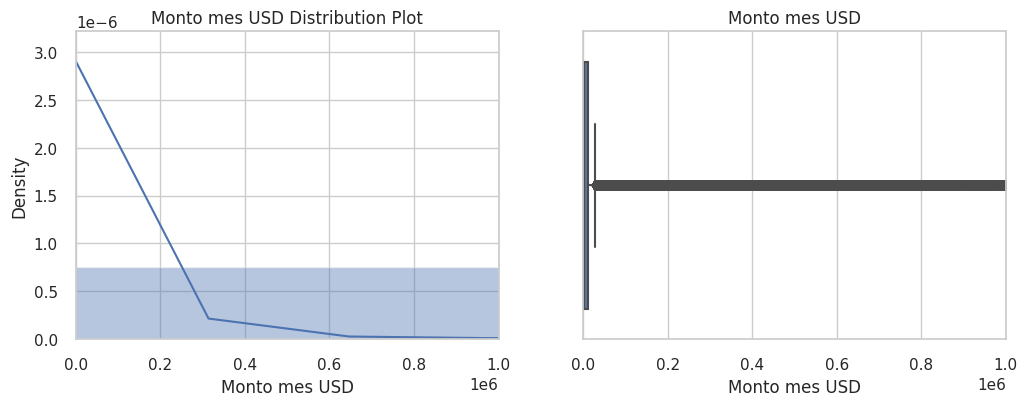

In [72]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Monto mes USD Distribution Plot')
sns.distplot(comercios_RL['Monto mes USD'])

plt.xlim(0, 1e6)

plt.subplot(1,2,2)
plt.title('Monto mes USD')
sns.boxplot(x=comercios_RL['Monto mes USD'])

plt.xlim(0, 1e6)

plt.show()

In [73]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(comercios_RL['Monto mes USD'].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count     103086
mean      114576
std      1177653
min            0
25%            1
50%         1124
75%        11602
85%        35185
90%        75398
95%       230652
97.5%     645950
100%    65468530
max     65468530
Name: Monto mes USD, dtype: float64


In [74]:
#Se crea un dataframe de prueba de un 10% de los datos
dPrueba = comercios_RL.sample(frac=0.1, random_state=1)

#se eliminan los datos de prueba del dataframe
d = comercios_RL.drop(index=dPrueba.index)

In [75]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop('Monto mes USD', axis=1)
y = d['Monto mes USD']

In [76]:
# División de los datos en train y test

#En este caso, el 80% de los datos se utilizarán para entrenar el modelo.

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

### Creación del modelo

In [77]:
#Llamamos la funcion build_model definida al principio de este notebook que crea y entrena el modelo

modelo_X_train = build_model(X_train,y_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     739.7
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:37:11   Log-Likelihood:            -1.1353e+06
No. Observations:               74221   AIC:                         2.271e+06
Df Residuals:                   74185   BIC:                         2.271e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

Dado que el p-value de variablas variables es mayor a 0.05 no hay suficiente evidencia para sugerir que las mismas tienen un efecto significativo sobre la variable dependiente. No obstante para conservar el alcance de esta primera corrida, se tendrá en cuenta la eliminación de las variables no significativas en una futura corrida

### Colinealidad

In [78]:
#Se aplica la funcion de Factor de Inflación de la Varianza (VIF- Variance Inflation Factor) para identificar colinealidad
#entre las variables

checkVIF(modelo_X_train)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
17,merchant_address_country_CW,inf
29,agrupación_mcc_Alojamiento,inf
24,merchant_enabled_Inactivo,inf
23,merchant_enabled_Activo,inf
27,agrupación_mcc_Aerolíneas,85791837761
19,merchant_address_country_HN,38783846327
13,merchant_address_country_BZ,21953946370
21,merchant_address_country_PR,16803002824
22,merchant_address_country_UY,8632414353
28,agrupación_mcc_Agricultura,7749748339


Si existe alguna *feature* > 10 debe eliminarse. Siendo estrictos se debe eliminar aquellas variables con VIF > 5.

Similar al apartado anterior, las características que cumplen dicha condición se podrán eliminar en una futura corrida.

**Nota:** Posteriormente a la eliminación, debe verificarse los *p-values* menores a 0.05 nuevamente.

In [79]:
#Se crea nuevamente el modelo con las variables anteriormente


#Se crea y se entrena el modelo de regresion lineal q(statsmodels.api)
lm = sm.OLS(y_train,modelo_X_train).fit()

#No es necesario adicionar la constante porque los datos devuelos en la variable 'modelo_X_train' ya contiene la constante

##Evaluación del modelo

### Entrenamiento

In [80]:
# Diagnóstico errores (residuos) de las predicciones de entrenamiento

#Reducción de dimensionalidad del dataset: se convierte en una dimensión
y_train = y_train.flatten()

#Se realiza la predicción sobre los datos de entrenamiento
prediccion_train = lm.predict(modelo_X_train)

#Se calculan los residuos: diferencia entre la prediccion y el valor real en los datos de entreanamiento
residuos_train   = prediccion_train - y_train

In [81]:
# Error de Entrenamiento del modelo
predicciones = lm.predict(exog = modelo_X_train)

mse = mean_squared_error (y_true  = y_train, y_pred  = predicciones, squared = True)
rmse = mean_squared_error (y_true  = y_train, y_pred  = predicciones, squared = False)
MAE = mean_absolute_error (y_true  = y_train, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = y_train, y_pred  = predicciones)
r2 = r2_score (y_true  = y_train, y_pred  = predicciones)

print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {MAE}")
print(f"El error MedAE de test es: {MedAE}")
print(f"El error R2    de test es: {r2}")

El error MSE   de test es: 1132564168253.4832
El error RMSE  de test es: 1064219.9811380554
El error MAE   de test es: 163880.93119833697
El error MedAE de test es: 57752.12064120476
El error R2    de test es: 0.2587114465973497


<ipython-input-82-307d74a81854>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


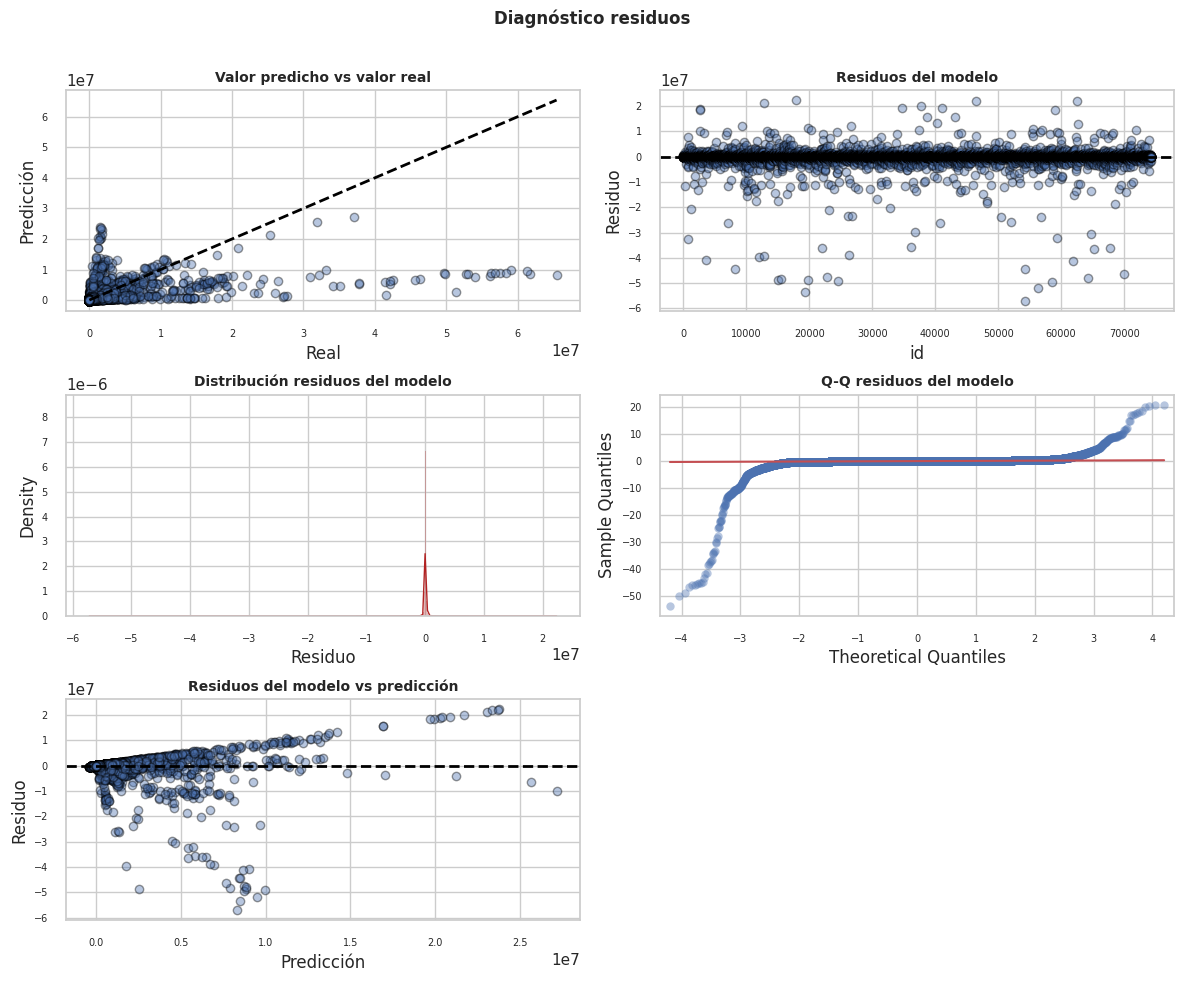

In [82]:
# Gráficos para el pronóstico de residuos

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residuos_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residuos_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1],
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediccion_train, residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize = 7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

### Test

In [83]:
#Se extraen solo las columnas que finalmente quedaron en X_train (excluyendo constante)
X_test = X_test[modelo_X_train.columns[1:len(modelo_X_train)]]

#Adicionamos la constante
X_test = sm.add_constant(X_test)

In [84]:
# Error de Entrenamiento del modelo


predicciones = lm.predict(exog = X_test)

mse = mean_squared_error (y_true  = y_test, y_pred  = predicciones, squared = True)
rmse = mean_squared_error (y_true  = y_test, y_pred  = predicciones, squared = False)
MAE = mean_absolute_error (y_true  = y_test, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = y_test, y_pred  = predicciones)
r2 = r2_score (y_true  = y_test, y_pred  = predicciones)

print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {MAE}")
print(f"El error MedAE de test es: {MedAE}")
print(f"El error R2    de test es: {r2}")

El error MSE   de test es: 917460338324.3258
El error RMSE  de test es: 957841.499583478
El error MAE   de test es: 167488.870461621
El error MedAE de test es: 57414.93233969882
El error R2    de test es: 0.24444335882846369


### Prueba

In [85]:
#Se extraen solo las columnas que finalmente quedaron en X_train (excluyendo constant)
dPrueba1 = dPrueba[modelo_X_train.columns[1:len(modelo_X_train)]]

#Se adiciona la constante a los datos de prueba
dPrueba1 = sm.add_constant(dPrueba1) #Adding the constant

dPrueba1.head()

,const,transaction_processing_period,transacciones mes,Pagadores mes,avg ticket,approval rate,Disputes,years_created,years_live,Sitios activos,merchant_classification,merchant_is_iata_travelagency,active_status,merchant_address_country_BZ,merchant_address_country_CL,merchant_address_country_CO,merchant_address_country_CR,merchant_address_country_CW,merchant_address_country_EC,merchant_address_country_HN,merchant_address_country_PA,merchant_address_country_PR,merchant_address_country_UY,merchant_enabled_Activo,merchant_enabled_Inactivo,site_classification_E-Commerce,site_classification_Recaudo,agrupación_mcc_Aerolíneas,agrupación_mcc_Agricultura,agrupación_mcc_Alojamiento,agrupación_mcc_Gubernamentales,agrupación_mcc_Minoristas,agrupación_mcc_Miscelaneas,agrupación_mcc_Negocios,agrupación_mcc_Servicios contractuales,agrupación_mcc_Servicios de utilidad,agrupación_mcc_Servicios profesionales y membresías,agrupación_mcc_Textil,agrupación_mcc_Transporte,Clases
42094,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,4
58504,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,3
40239,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
35389,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3
90874,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2


In [86]:
#Se realiza una predicción con el modelo de prueba
prediccion = lm.predict(exog = dPrueba1)


#Se crea un dataframe con con el monto calculado a partir del modelo
dfPred = pd.DataFrame(prediccion, columns=['MontoCal'])

#Se adiciona el precio del dataframe de prueba
pred= pd.merge(dfPred, dPrueba['Monto mes USD'],  left_index=True, right_index=True)

#Se calcula la diferencia (el valor absoluto) entre los dos valores: el real y el encontrado con el modelo
pred['diff'] = abs(pred['Monto mes USD'] - pred['MontoCal'])

pred.head(10)

,MontoCal,Monto mes USD,diff
42094,100847,1612,99235
58504,-6273,2131,8404
40239,-109027,1271,110298
35389,-68125,0,68125
90874,-79772,0,79772
77146,-114636,0,114636
64630,-64147,141,64288
9643,-11678,279,11957
906,78634,888,77746
95454,63041,0,63041


In [87]:
mse = mean_squared_error (y_true  = pred['Monto mes USD'], y_pred  = prediccion, squared = True)
rmse = mean_squared_error (y_true  = pred['Monto mes USD'], y_pred  = prediccion, squared = False)
MAE = mean_absolute_error (y_true  = pred['Monto mes USD'], y_pred  = prediccion)
MedAE = median_absolute_error (y_true  = pred['Monto mes USD'], y_pred  = prediccion)
r2 = r2_score (y_true  = pred['Monto mes USD'], y_pred  = prediccion)

print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {MAE}")
print(f"El error MedAE de test es: {MedAE}")
print(f"El error R2    de test es: {r2}")

El error MSE   de test es: 601031686953.1589
El error RMSE  de test es: 775262.3342799254
El error MAE   de test es: 155607.14971023536
El error MedAE de test es: 58725.41701909646
El error R2    de test es: 0.11883478572455408


# Algunos aprendizajes

*   **Carga del archivo.** El archivo fue entregado por la empresa en formato csv, sin embargo, al intentar cargarlo se presentaba el error `'utf-8' codec can't decode byte 0xf3 in position 4508: invalid continuation byte` el cual se intentó solucionar con el parámetro **"`encoding = latin-1`"** el cuál mostró otro error `ParserError: Error tokenizing data. C error: Expected 7 fields in line 40, saw 10`. Al verificar en la base de datos no se encontraron registros dañados, columnas ocultas, sobrantes o faltantes, por lo que se concluyó que pudo ser un error de como se guardó el archivo. Por ende, se preocedió a guardarlo como archivo de excel y se cargo en este formato, solucinando el problema de lectura de archivo.


*   **Eliminación de variables.** En nuestro ejercicio fue fundamental comunicarnos con la empresa y comprender bien cada una de las variables. Para ello, se creo un diccionario donde se explica el contenido de cada variable, y, se realizaron dos reuniones para resolver dudas. A raíz de estos encuentros, comprendimos que de entrada hay algunas variables innecesarias, y, que hay variables que parecen irrelevantes pero que para el negocio son importantes. Por ejemplo, la variable **`"merchant_is_iata_travelagency"`** que define si un comercio es una agencia de viajes o no, resulta irrelevante a primera vista, pero, para la empresa es importante porque los servicios que ofrecen a las agencias de viajes son diferenciales de otros servicios.



*   **Creación de nuevas variables.** Igualmente, a partir del entendimiento del negocio, nos planteamos crear nuevas variables que pueden proporcionarnos información importante. Ejemplo, poder ver la antigüedad de los comercios en años, establecer una regla de negocio que indique cuando un cliente está inactivo, en nuestro caso, se determinó que aquellos negocios que no realizaban transacciones en un período de un año o más, se consideraban inactivos.


*   **Etiquetado de la variable `merchant_classification`.** Decidimos realizar una codificación de etiquetas a la variable merchant_classification en vez de un one hot encoding, debido a que las categorías representan unos grados de volumetría, en este caso, A es más cercano a A+ como el 5 es más cercano a 6. Al utilizar estrategias de distancia, puede ser más adecuado este tipo de codificación para la variable en mención.










# Trabajo futuro

* Realizar una selección de características midiendo que tanta información aportan T-student.

* Reducción de componentes para reducir el costo computacional.

* Agregar la métrica de Dunn al clustering una vez se cuente con una reducción de componentes y de costo computacional.